In [1]:
# import numpy as np

# # !/usr/bin/env python3
# # -*- coding: utf-8 -*-
# """
# Created on 20181219

# @author: zhangji

# Trajection of a ellipse, Jeffery equation. 
# """

# %pylab inline
# pylab.rcParams['figure.figsize'] = (25, 11)
# fontsize = 40

# import numpy as np
# import scipy as sp
# from scipy.optimize import leastsq, curve_fit
# from scipy import interpolate
# from scipy.interpolate import interp1d
# from scipy.io import loadmat, savemat
# # import scipy.misc

# import matplotlib
# from matplotlib import pyplot as plt
# from matplotlib import animation, rc
# import matplotlib.ticker as mtick
# from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
# from mpl_toolkits.mplot3d import Axes3D, axes3d

# from sympy import symbols, simplify, series, exp
# from sympy.matrices import Matrix
# from sympy.solvers import solve

# from IPython.display import display, HTML
# from tqdm import tqdm_notebook as tqdm
# import pandas as pd
# import re
# from scanf import scanf
# import os
# import glob

# from codeStore import support_fun as spf
# from src.support_class import *
# from src import stokes_flow as sf

# rc('animation', html='html5')
# PWD = os.getcwd()
# font = {'size': 20}
# matplotlib.rc('font', **font)
# np.set_printoptions(linewidth=90, precision=5)

import os
import glob
import natsort 
import numpy as np
import scipy as sp
from scipy.optimize import leastsq, curve_fit
from scipy import interpolate
from scipy import spatial
# from scipy.interpolate import interp1d
from scipy.io import loadmat, savemat
# import scipy.misc
import importlib
from IPython.display import display, HTML
import pandas as pd
import pickle

import matplotlib
from matplotlib import pyplot as plt
# from matplotlib import colors as mcolors
import matplotlib.colors as colors
from matplotlib import animation, rc
import matplotlib.ticker as mtick
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
from mpl_toolkits.mplot3d import Axes3D, axes3d
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from matplotlib import cm

from time import time
from src.support_class import *
from src import jeffery_model as jm
from codeStore import support_fun as spf

# %matplotlib notebook

rc('animation', html='html5')
fontsize = 40
PWD = os.getcwd()

In [315]:
def show_ecoli_results(t_t, t_theta, t_phi, t_psi, t_dtheta, t_dphi, t_X, t_U, t_P, label=' '):
    t_eta = np.arccos(np.sin(t_theta) * np.sin(t_phi))

    # show norm and direction.
    fig = plt.figure(figsize=(30, 20))
    fig.patch.set_facecolor('white')
    ax00 = plt.subplot2grid((4, 2), (0, 0), rowspan=2)
    ax01 = plt.subplot2grid((4, 2), (2, 0))
    ax02 = plt.subplot2grid((4, 2), (3, 0))
    ax1 = plt.subplot2grid((4, 2), (0, 1), )
    ax2 = plt.subplot2grid((4, 2), (1, 1), )
    ax3 = plt.subplot2grid((4, 2), (2, 1), )
    ax4 = plt.subplot2grid((4, 2), (3, 1), )
    norm = plt.Normalize(t_t.min(), t_t.max())
    cmap = plt.get_cmap('jet')
    plt.sca(ax00)
    # ax00.plot(t_phi / np.pi, t_theta / np.pi, '')
    # lc = spf.colorline(t_phi / np.pi, t_theta / np.pi, t_t,
    #                    ax=ax00, cmap=cmap, norm=norm, linewidth=3)
    lc = ax00.scatter(t_phi / np.pi, t_theta / np.pi,
                      c=t_t, cmap=cmap, norm=norm, s=3)
    clb = fig.colorbar(lc, ax=ax00, orientation="vertical")
    clb.ax.tick_params(labelsize=fontsize * 0.8)
    ax00.set_xlabel('$\\phi / \pi$', size=fontsize)
    ax00.set_ylabel('$\\theta / \pi$', size=fontsize)
    plt.xticks(fontsize=fontsize * 0.8)
    plt.yticks(fontsize=fontsize * 0.8)
    ax00.set_xlim(0, 2)
    ax00.set_ylim(0, 1)

    for axi, ty, axyi in zip((ax1, ax2, ax3, ax4, ax01, ax02),
                             (t_theta / np.pi, t_phi / np.pi, t_psi / np.pi, t_eta / np.pi,
                              t_dtheta, t_dphi),
                             ('$\\theta / \pi$', '$\\phi / \pi$', '$\\psi / \pi$', '$\\eta / \pi$',
                              '$d\\theta$', '$d\\phi$')):
        plt.sca(axi)
        axi.plot(t_t, ty, '-*', label=label)
        axi.set_xlabel('t', size=fontsize)
        axi.set_ylabel('%s' % axyi, size=fontsize)
        #     axi.legend()
        plt.xticks(fontsize=fontsize * 0.8)
        plt.yticks(fontsize=fontsize * 0.8)
    plt.tight_layout()

    fig = plt.figure(figsize=(8, 8))
    fig.patch.set_facecolor('white')
    ax0 = fig.add_subplot(3, 2, 1)
    ax1 = fig.add_subplot(3, 2, 3)
    ax2 = fig.add_subplot(3, 2, 5)
    ax3 = fig.add_subplot(3, 2, 2)
    ax4 = fig.add_subplot(3, 2, 4)
    ax5 = fig.add_subplot(3, 2, 6)
    ax0.plot(t_t, t_U[:, 0], '-*', label=label)
    ax1.plot(t_t, t_U[:, 1], '-*', label=label)
    ax2.plot(t_t, t_U[:, 2], '-*', label=label)
    ax3.plot(t_t, t_U[:, 3], '-*', label=label)
    ax4.plot(t_t, t_U[:, 4], '-*', label=label)
    ax5.plot(t_t, t_U[:, 5], '-*', label=label)
    for axi, axyi in zip((ax0, ax1, ax2, ax3, ax4, ax5,), ('Ux', 'Uy', 'Uz', 'Wx', 'Wy', 'Wz')):
        axi.set_xlabel('t')
        axi.set_ylabel('%s' % axyi)
        axi.legend()
    plt.tight_layout()

    fig = plt.figure(figsize=(8, 8))
    fig.patch.set_facecolor('white')
    ax0 = fig.add_subplot(3, 2, 1)
    ax1 = fig.add_subplot(3, 2, 3)
    ax2 = fig.add_subplot(3, 2, 5)
    ax3 = fig.add_subplot(3, 2, 2)
    ax4 = fig.add_subplot(3, 2, 4)
    ax5 = fig.add_subplot(3, 2, 6)
    ax0.plot(t_t, t_X[:, 0], '-*', label=label)
    ax1.plot(t_t, t_X[:, 1], '-*', label=label)
    ax2.plot(t_t, t_X[:, 2], '-*', label=label)
    ax3.plot(t_t, t_P[:, 0], '-*', label=label)
    ax4.plot(t_t, t_P[:, 1], '-*', label=label)
    ax5.plot(t_t, t_P[:, 2], '-*', label=label)
    for axi, axyi in zip((ax0, ax1, ax2, ax3, ax4, ax5), ('center_x', 'center_y', 'center_z', 'Px', 'Py', 'Pz')):
        axi.set_xlabel('t')
        axi.set_ylabel('%s' % axyi)
        axi.legend()
    plt.tight_layout()

    # trajectory
    fig = plt.figure(figsize=(20, 20))
    fig.patch.set_facecolor('white')
    ax0 = fig.add_subplot(1, 1, 1, projection='3d')
    cax1 = inset_axes(ax0, width="100%", height="5%", bbox_to_anchor=(0, 0.1, 1, 1),
                      loc=1, bbox_transform=ax0.transAxes, borderpad=0, )
    norm = plt.Normalize(t_t.min(), t_t.max())
    cmap = plt.get_cmap('jet')
    # Create the 3D-line collection object
    points = t_X.reshape(-1, 1, 3)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    lc = Line3DCollection(segments, cmap=cmap, norm=norm)
    lc.set_array(t_t)
    ax0.add_collection3d(lc, zs=points[:, :, 2].flatten(), zdir='z')
    ax0.set_xlim(points[:, :, 0].min(), points[:, :, 0].max())
    ax0.set_ylim(points[:, :, 1].min(), points[:, :, 1].max())
    ax0.set_zlim(points[:, :, 2].min(), points[:, :, 2].max())
    # spf.set_axes_equal(ax0)
    # ax0.plot(np.ones_like(points[:, :, 0].flatten())*ax0.get_xlim()[0], points[:, :, 1].flatten(), points[:, :, 2].flatten())
    # ax0.plot(points[:, :, 0].flatten(), np.ones_like(points[:, :, 1].flatten())*ax0.get_ylim()[1], points[:, :, 2].flatten())
    # ax0.plot(points[:, :, 0].flatten(), points[:, :, 1].flatten(), np.ones_like(points[:, :, 2].flatten())*ax0.get_zlim()[0])
    clb = fig.colorbar(lc, cax=cax1, orientation="horizontal")
    clb.ax.tick_params(labelsize=fontsize)
    clb.ax.set_title('Sim, time', size=fontsize)
    plt.sca(ax0)
    ax0.set_xlabel('X', size=fontsize)
    ax0.set_ylabel('Y', size=fontsize)
    ax0.set_zlabel('Z', size=fontsize)
    plt.xticks(fontsize=fontsize * 0.8)
    plt.yticks(fontsize=fontsize * 0.8)
    for t in ax0.zaxis.get_major_ticks():
        t.label.set_fontsize(fontsize * 0.8)
    for spine in ax0.spines.values():
        spine.set_visible(False)
    # t_stp = t_X.shape[0] // 100
    # color_len = t_X[::t_stp, 0].size
    # quiver_length = np.max(t_X.max(axis=0) - t_X.min(axis=0)) * 0.05
    # colors = [cmap(1.*i/color_len) for i in range(color_len)]
    # ax0.quiver(t_X[::t_stp, 0], t_X[::t_stp, 1], t_X[::t_stp, 2],
    #            t_P[::t_stp, 0], t_P[::t_stp, 1], t_P[::t_stp, 2],
    #            length=quiver_length, arrow_length_ratio=0.2, pivot='middle', normalize=False, colors=colors)
    plt.tight_layout()

    # speed
    fig = plt.figure(figsize=(40, 20))
    fig.patch.set_facecolor('white')
    ax0 = fig.add_subplot(1, 2, 1, projection='3d')
    ax1 = fig.add_subplot(1, 2, 2, projection='3d')
    # U
    ax0.set_title('t_U', size=fontsize)
    cax0 = inset_axes(ax0, width="80%", height="5%", bbox_to_anchor=(0, 0.1, 1, 1),
                      loc=1, bbox_transform=ax0.transAxes, borderpad=0, )
    norm = plt.Normalize(t_t.min(), t_t.max())
    cmap = plt.get_cmap('jet')
    # Create the 3D-line collection object
    points = t_U[:, :3].reshape(-1, 1, 3)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    lc = Line3DCollection(segments, cmap=cmap, norm=norm)
    lc.set_array(t_t)
    ax0.add_collection3d(lc, zs=points[:, :, 2].flatten(), zdir='z')
    ax0.set_xlim(points[:, :, 0].min(), points[:, :, 0].max())
    ax0.set_ylim(points[:, :, 1].min(), points[:, :, 1].max())
    ax0.set_zlim(points[:, :, 2].min(), points[:, :, 2].max())
    spf.set_axes_equal(ax0)
    ax0.plot(np.ones_like(points[:, :, 0].flatten()) * ax0.get_xlim()[0], points[:, :, 1].flatten(),
             points[:, :, 2].flatten())
    ax0.plot(points[:, :, 0].flatten(), np.ones_like(points[:, :, 1].flatten()) * ax0.get_ylim()[1],
             points[:, :, 2].flatten())
    ax0.plot(points[:, :, 0].flatten(), points[:, :, 1].flatten(),
             np.ones_like(points[:, :, 2].flatten()) * ax0.get_zlim()[0])
    clb = fig.colorbar(lc, cax=cax0, orientation="horizontal")
    clb.ax.tick_params(labelsize=fontsize)
    clb.ax.set_title('Sim, time', size=fontsize)
    plt.sca(ax0)
    ax0.set_xlabel('ux', size=fontsize)
    ax0.set_ylabel('uy', size=fontsize)
    ax0.set_zlabel('uz', size=fontsize)
    plt.xticks(fontsize=fontsize * 0.8)
    plt.yticks(fontsize=fontsize * 0.8)
    for t in ax0.zaxis.get_major_ticks():
        t.label.set_fontsize(fontsize * 0.8)
    for spine in ax0.spines.values():
        spine.set_visible(False)
    # W
    ax1.set_title('ecoli_W', size=fontsize)
    cax1 = inset_axes(ax1, width="80%", height="5%", bbox_to_anchor=(0, 0.1, 1, 1),
                      loc=1, bbox_transform=ax1.transAxes, borderpad=0, )
    norm = plt.Normalize(t_t.min(), t_t.max())
    cmap = plt.get_cmap('jet')
    # Create the 3D-line collection object
    points = t_U[:, 3:].reshape(-1, 1, 3)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    lc = Line3DCollection(segments, cmap=cmap, norm=norm)
    lc.set_array(t_t)
    ax1.add_collection3d(lc, zs=points[:, :, 2].flatten(), zdir='z')
    ax1.set_xlim(points[:, :, 0].min(), points[:, :, 0].max())
    ax1.set_ylim(points[:, :, 1].min(), points[:, :, 1].max())
    ax1.set_zlim(points[:, :, 2].min(), points[:, :, 2].max())
    spf.set_axes_equal(ax1)
    ax1.plot(np.ones_like(points[:, :, 0].flatten()) * ax1.get_xlim()[0], points[:, :, 1].flatten(),
             points[:, :, 2].flatten())
    ax1.plot(points[:, :, 0].flatten(), np.ones_like(points[:, :, 1].flatten()) * ax1.get_ylim()[1],
             points[:, :, 2].flatten())
    ax1.plot(points[:, :, 0].flatten(), points[:, :, 1].flatten(),
             np.ones_like(points[:, :, 2].flatten()) * ax1.get_zlim()[0])
    clb = fig.colorbar(lc, cax=cax1, orientation="horizontal")
    clb.ax.tick_params(labelsize=fontsize)
    clb.ax.set_title('Sim, time', size=fontsize)
    plt.sca(ax1)
    ax1.set_xlabel('wx', size=fontsize)
    ax1.set_ylabel('wy', size=fontsize)
    ax1.set_zlabel('wz', size=fontsize)
    plt.xticks(fontsize=fontsize * 0.8)
    plt.yticks(fontsize=fontsize * 0.8)
    for t in ax1.zaxis.get_major_ticks():
        t.label.set_fontsize(fontsize * 0.8)
    for spine in ax1.spines.values():
        spine.set_visible(False)
    plt.tight_layout()

    # norm
    fig = plt.figure(figsize=(20, 20))
    fig.patch.set_facecolor('white')
    ax0 = fig.add_subplot(1, 1, 1, projection='3d')
    ax0.set_title('ecoli_norm', size=fontsize)
    cax0 = inset_axes(ax0, width="80%", height="5%", bbox_to_anchor=(0, 0.1, 1, 1),
                      loc=1, bbox_transform=ax0.transAxes, borderpad=0, )
    norm = plt.Normalize(t_t.min(), t_t.max())
    cmap = plt.get_cmap('jet')
    # Create the 3D-line collection object
    points = t_P.reshape(-1, 1, 3)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    lc = Line3DCollection(segments, cmap=cmap, norm=norm)
    lc.set_array(t_t)
    ax0.add_collection3d(lc, zs=points[:, :, 2].flatten(), zdir='z')
    ax0.set_xlim(points[:, :, 0].min(), points[:, :, 0].max())
    ax0.set_ylim(points[:, :, 1].min(), points[:, :, 1].max())
    ax0.set_zlim(points[:, :, 2].min(), points[:, :, 2].max())
    spf.set_axes_equal(ax0)
    ax0.plot(np.ones_like(points[:, :, 0].flatten()) * ax0.get_xlim()[0], points[:, :, 1].flatten(),
             points[:, :, 2].flatten())
    ax0.plot(points[:, :, 0].flatten(), np.ones_like(points[:, :, 1].flatten()) * ax0.get_ylim()[1],
             points[:, :, 2].flatten())
    ax0.plot(points[:, :, 0].flatten(), points[:, :, 1].flatten(),
             np.ones_like(points[:, :, 2].flatten()) * ax0.get_zlim()[0])
    clb = fig.colorbar(lc, cax=cax0, orientation="horizontal")
    clb.ax.tick_params(labelsize=fontsize)
    clb.ax.set_title('Sim, time', size=fontsize)
    plt.sca(ax0)
    ax0.set_xlabel('px', size=fontsize)
    ax0.set_ylabel('py', size=fontsize)
    ax0.set_zlabel('pz', size=fontsize)
    plt.xticks(fontsize=fontsize * 0.8)
    plt.yticks(fontsize=fontsize * 0.8)
    for t in ax0.zaxis.get_major_ticks():
        t.label.set_fontsize(fontsize * 0.8)
    for spine in ax0.spines.values():
        spine.set_visible(False)
    plt.tight_layout()
    return True

def get_ecoli_date(dir_name, file_handle, ignore_first=0):
    importlib.reload(jm)
    mat_names = natsort.natsorted(glob.glob('%s/%s_*.mat' % (dir_name, file_handle)))
    print(file_handle, len(mat_names))
    ecoli_U_list = []
    ecoli_norm_list = []
    ecoli_center_list = []
    ecoli_nodes_list = []
    # ecoli_u_list = []
    # ecoli_f_list = []
    ti_list = []
    tail_rel_U_list = []
    for mati in mat_names[ignore_first:]:
        mat_contents = loadmat(mati)
        ecoli_U = mat_contents['ecoli_U'].flatten()
        ecoli_norm = mat_contents['ecoli_norm'].flatten()
        ecoli_center = mat_contents['ecoli_center'].flatten()
        ecoli_nodes = mat_contents['ecoli_nodes']
        # ecoli_u = mat_contents['ecoli_u']
        # ecoli_f = mat_contents['ecoli_f']
        # planeShearRate = mat_contents['planeShearRate'].flatten()
        ti = mat_contents['ti'].flatten()
        tail_rel_U = mat_contents['tail_rel_U'].flatten()
        ecoli_U_list.append(ecoli_U)
        ecoli_norm_list.append(ecoli_norm)
        ecoli_center_list.append(ecoli_center)
        ecoli_nodes_list.append(ecoli_nodes)
        ti_list.append(ti)
        tail_rel_U_list.append(tail_rel_U)
    ecoli_U = np.vstack(ecoli_U_list)
    ecoli_norm = np.vstack(ecoli_norm_list)
    ecoli_center = np.vstack(ecoli_center_list)
    ecoli_t = np.hstack(ti_list)
    tail_rel_U = np.vstack(tail_rel_U_list)
    omega_norm = np.array([np.dot(t1, t2) * t2 / np.dot(t2, t2) for t1, t2 in zip(ecoli_U[:, 3:], ecoli_norm)])
    omega_tang = ecoli_U[:, 3:] - omega_norm
    ecoli_theta = np.arccos(ecoli_norm[:, 2] / np.linalg.norm(ecoli_norm, axis=1))
    t_phi = np.arctan2(ecoli_norm[:, 1], ecoli_norm[:, 0])
    ecoli_phi = np.hstack([t1 + 2 * np.pi if t1 < 0 else t1 for t1 in t_phi])

    omega = ecoli_U[:, 3:]
    dP = np.vstack([np.cross(t1, t2) for t1, t2 in zip(omega, ecoli_norm)])
    ecoli_dtheta = -dP[:, 2] / np.sin(np.abs(ecoli_theta))
    ecoli_dphi = (dP[:, 1] * np.cos(ecoli_phi) - dP[:, 0] * np.sin(ecoli_phi)) / np.sin(ecoli_theta)

    ecoli_lateral_norm = []
    ecoli_psi = []
#     idx = np.random.randint(0, ecoli_nodes_list[0].shape[0], 1)[0]
    idx = -1
    for t_nodes, t_center, t_norm in zip(ecoli_nodes_list, ecoli_center, ecoli_norm):
        r0 = t_nodes[idx] - t_center
        n0 = np.dot(r0, t_norm) * t_norm / np.dot(t_norm, t_norm)
        t0 = r0 - n0
        ecoli_lateral_norm.append(t0 / np.linalg.norm(t0))
    ecoli_lateral_norm = np.vstack(ecoli_lateral_norm)
    t_lateral_norm0 = ecoli_lateral_norm[0]
    t_norm0 = ecoli_norm[0]
    for t_lateral_norm, t_theta, t_phi in zip(ecoli_lateral_norm, ecoli_theta, ecoli_phi):
        t_lateral_norm = vector_rotation(t_lateral_norm, norm=np.array((0, 0, 1)), theta=-t_phi)
        t_lateral_norm = vector_rotation(t_lateral_norm, norm=np.array((0, 1, 0)), theta=ecoli_theta[0] - t_theta)
        t_lateral_norm = vector_rotation(t_lateral_norm, norm=np.array((0, 0, 1)), theta=ecoli_phi[0])
        sign = np.sign(np.dot(t_norm0, np.cross(t_lateral_norm0, t_lateral_norm)))
        t_psi = sign * np.arccos(np.clip(np.dot(t_lateral_norm0, t_lateral_norm) / np.linalg.norm(t_lateral_norm)
                                         / np.linalg.norm(t_lateral_norm0), -1, 1))
        t_psi = t_psi + 2 * np.pi if t_psi < 0 else t_psi  # (-pi,pi) -> (0, 2pi)
        ecoli_psi.append(t_psi)
    ecoli_psi = np.hstack(ecoli_psi).flatten()
    
    # show ini position of ecoli
    fig = plt.figure(figsize=(20, 15))
    fig.patch.set_facecolor('white')
    ax = axes3d.Axes3D(fig)
    for spine in ax.spines.values(): spine.set_visible(False)
    t1 = ecoli_nodes_list[0]
    plt.sca(ax)
    ax.plot(t1[:, 0], t1[:, 1], t1[:, 2])
    spf.set_axes_equal(ax)
    ax.set_xlabel('X', size=fontsize*0.8)
    ax.set_ylabel('Y', size=fontsize*0.8)
    ax.set_zlabel('Z', size=fontsize*0.8)
    ax.set_title(file_handle, size=fontsize)
    plt.xticks(fontsize=fontsize*0.8)
    plt.yticks(fontsize=fontsize*0.8)
    for t in ax.zaxis.get_major_ticks(): t.label.set_fontsize(fontsize*0.8)
    return ecoli_t, ecoli_theta, ecoli_phi, ecoli_psi, ecoli_dtheta, ecoli_dphi, \
           ecoli_center, ecoli_U, ecoli_norm, ecoli_nodes_list

def show_ecoli_results_fft(t_t, t_theta, t_phi, t_psi, t_dtheta, t_dphi, t_X, t_U, t_P):
    t_eta = np.arccos(np.sin(t_theta) * np.sin(t_phi))
    dt = np.mean(np.diff(t_t))

    # show fft of norm and direction.
    fig = plt.figure(figsize=(30, 20))
    fig.patch.set_facecolor('white')
    axs = fig.subplots(nrows=3, ncols=2)
    for axi, ty, axyi in zip(axs.flatten(),
                             (t_theta / np.pi, t_phi / np.pi, t_psi / np.pi, t_eta / np.pi,
                              t_dtheta, t_dphi),
                             ('$\\theta / \pi$', '$\\phi / \pi$', '$\\psi / \pi$', '$\\eta / \pi$',
                              '$d\\theta$', '$d\\phi$')):
        ty = ty[np.isfinite(ty)]
        t_fft = np.fft.rfft(ty)
        t_freq = np.fft.rfftfreq(ty.shape[0], dt)
        plt.sca(axi)
        axi.loglog(t_freq, np.abs(t_fft), '-*', label='Table')
        axi.set_xlabel('Freq (Hz)', size=fontsize)
        axi.set_ylabel('Amplitude_%s' % axyi, size=fontsize)
        plt.xticks(fontsize=fontsize * 0.8)
        plt.yticks(fontsize=fontsize * 0.8)
    plt.tight_layout()
    
    # fft of t_U
    fig = plt.figure(figsize=(30, 20))
    fig.patch.set_facecolor('white')    
    axs = fig.subplots(nrows=3, ncols=2)
    for axi, ty, axyi in zip(axs.T.flatten(), t_U.T, ('Ux', 'Uy', 'Uz', 'Wx', 'Wy', 'Wz')):
        ty = ty[np.isfinite(ty)]
        t_fft = np.fft.rfft(ty)
        t_freq = np.fft.rfftfreq(ty.shape[0], dt)
        plt.sca(axi)
        axi.loglog(t_freq, np.abs(t_fft), '-*', label='Table')
        axi.set_xlabel('Freq (Hz)', size=fontsize)
        axi.set_ylabel('Amplitude_%s' % axyi, size=fontsize)
        plt.xticks(fontsize=fontsize * 0.8)
        plt.yticks(fontsize=fontsize * 0.8)
    plt.tight_layout()

    # fft of t_X
    fig = plt.figure(figsize=(30, 20))
    fig.patch.set_facecolor('white')    
    axs = fig.subplots(nrows=3, ncols=2)
    for axi, ty, axyi in zip(axs.T.flatten(), np.hstack((t_X, t_P)).T, 
                             ('center_x', 'center_y', 'center_z', 'Px', 'Py', 'Pz')):
        ty = ty[np.isfinite(ty)]
        t_fft = np.fft.rfft(ty)
        t_freq = np.fft.rfftfreq(ty.shape[0], dt)
        plt.sca(axi)
        axi.loglog(t_freq, np.abs(t_fft), '-*', label='Table')
        axi.set_xlabel('Freq (Hz)', size=fontsize)
        axi.set_ylabel('Amplitude_%s' % axyi, size=fontsize)
        plt.xticks(fontsize=fontsize * 0.8)
        plt.yticks(fontsize=fontsize * 0.8)
    plt.tight_layout()
    return True

def get_ecoli_table(tnorm, lateral_norm, tcenter, max_iter, eval_dt=0.001, update_order=1,
                    planeShearRate=np.array((1, 0, 0))):
    from time import time
    t0 = time()
    ellipse_kwargs = {'name':         'ecoli_torque',
                      'center':       tcenter,
                      'norm':         tnorm / np.linalg.norm(tnorm),
                      'lateral_norm': lateral_norm / np.linalg.norm(lateral_norm),
                      'speed':        0,
                      'lbd':          np.nan,
                      'omega_tail':   193.66659814,
                      'table_name':   'planeShearRatex_1c', }
    fileHandle = 'ShearTableProblem'
    ellipse_obj = jm.TableEcoli(**ellipse_kwargs)
    ellipse_obj.set_update_para(fix_x=False, fix_y=False, fix_z=False, update_order=update_order)
    problem = jm.ShearTableProblem(name=fileHandle, planeShearRate=planeShearRate)
    problem.add_obj(ellipse_obj)
    for idx in range(1, max_iter + 1):
        problem.update_location(eval_dt, print_handle='%d / %d' % (idx, max_iter))
    Table_X = np.vstack(ellipse_obj.center_hist)
    Table_U = np.vstack(ellipse_obj.U_hist)
    Table_P = np.vstack(ellipse_obj.norm_hist)
    Table_t = np.arange(max_iter) * eval_dt + eval_dt
    Table_theta, Table_phi, Table_psi = ellipse_obj.theta_phi_psi
    t1U = np.array([np.dot(t1, t2) for t1, t2 in zip(Table_U[:, :3], Table_P)]).reshape((-1, 1))
    t1W = np.array([np.dot(t1, t2) for t1, t2 in zip(Table_U[:, 3:], Table_P)]).reshape((-1, 1))
#     Table_U_horizon = np.hstack((Table_P * t1U, Table_P * t1W))
#     Table_U_vertical = Table_U - Table_U_horizon
    omega = Table_U[:, 3:]
    dP = np.vstack([np.cross(t1, t2) for t1, t2 in zip(omega, Table_P)])
    Table_dtheta = -dP[:, 2] / np.sin(np.abs(Table_theta))
    Table_dphi = (dP[:, 1] * np.cos(Table_phi) - dP[:, 0] * np.sin(Table_phi)) / np.sin(Table_theta)
    Table_eta = np.arccos(np.sin(Table_theta) * np.sin(Table_phi))
    t1 = time()
    print('%s: run %d loops using %fs' % (fileHandle, max_iter, (t1 - t0)))
    return Table_t, Table_theta, Table_phi, Table_psi, Table_eta, Table_dtheta, Table_dphi, \
           Table_X, Table_U, Table_P


In [ ]:
table_data = (Table_t, Table_theta, Table_phi, Table_psi, Table_dtheta, Table_dphi, 
                   Table_X, Table_U, Table_P)
theta = np.arccos(tnorm[2] / np.linalg.norm(tnorm))
phi = np.arctan2(tnorm[1], tnorm[0])
phi = phi + 2 * np.pi if phi < 0 else phi
t_name = 'ecoli_table_%4.2f_%4.2f.pickle' % (theta, phi)
with open(t_name, 'wb') as handle:
    pickle.dump(tpick, handle, protocol=pickle.HIGHEST_PROTOCOL)
print('save table_data to %s' % t_name)

In [326]:
theta = np.arccos(tnorm[2] / np.linalg.norm(tnorm))
phi = np.arctan2(tnorm[1], tnorm[0])
phi = phi + 2 * np.pi if phi < 0 else phi
print(theta, phi)

0.0 0.0


ini norm= [ 0.  0.  1.] ellipse_speed= 0
ShearTableProblem: run 1000000 loops using 1849.183926


/home/zhangji/anaconda3/lib/python3.5/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


True

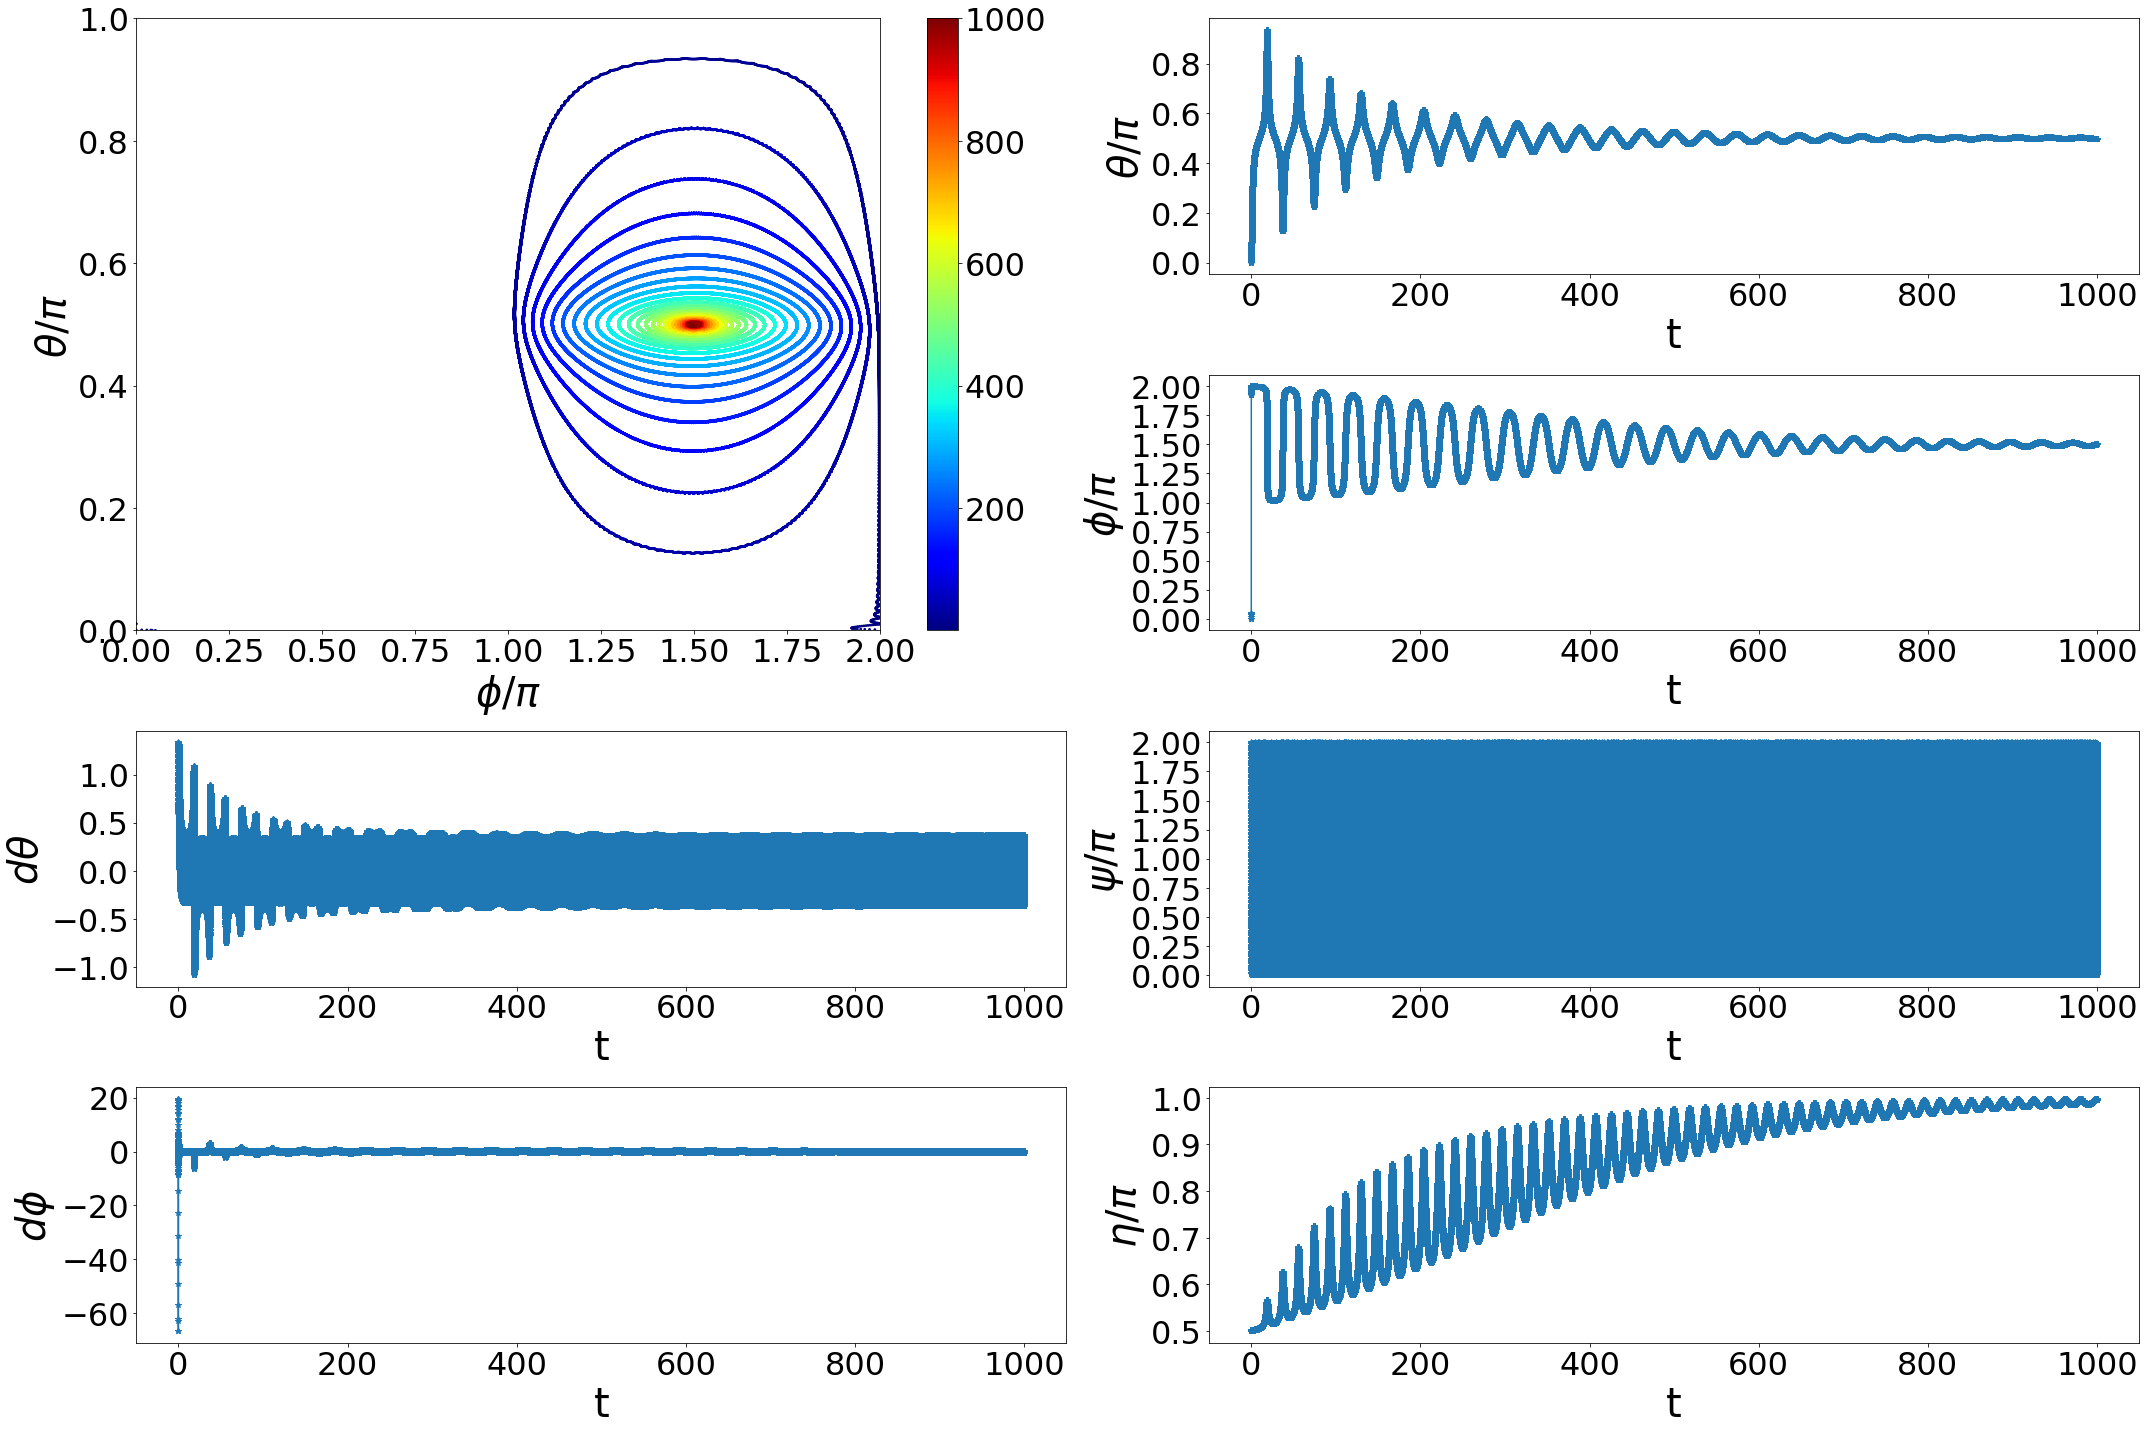

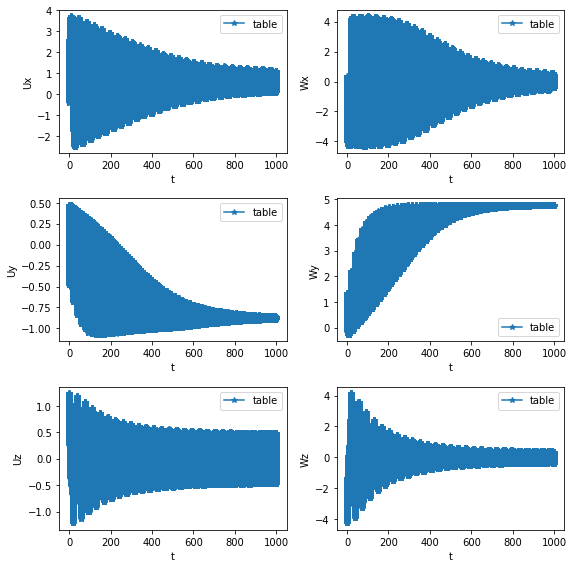

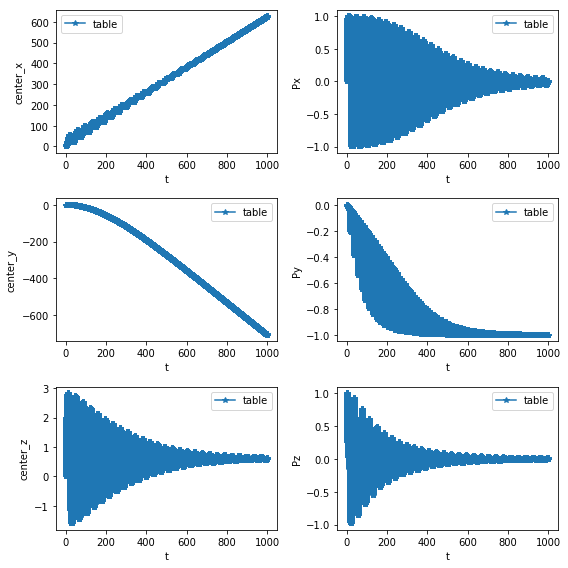

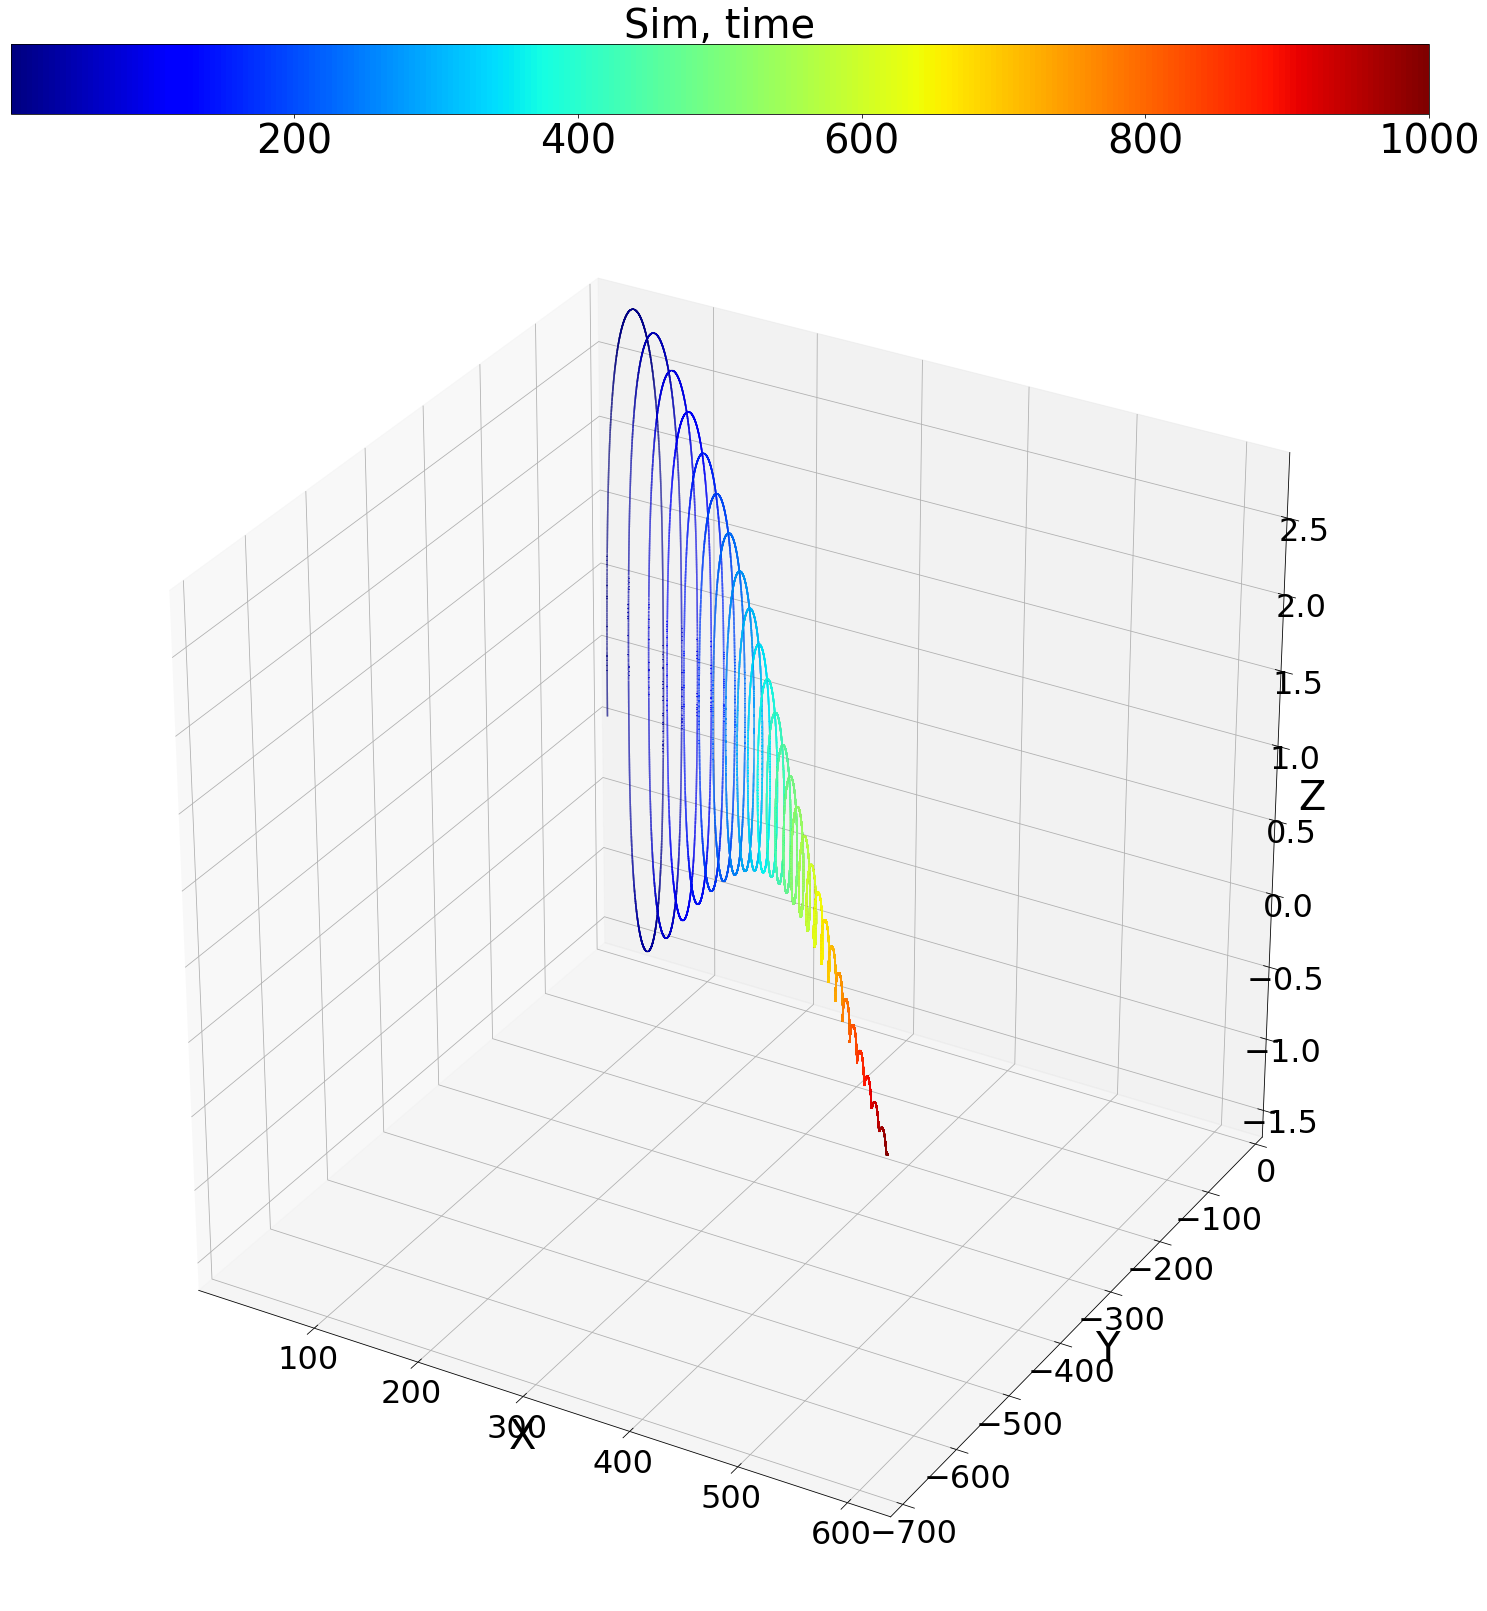

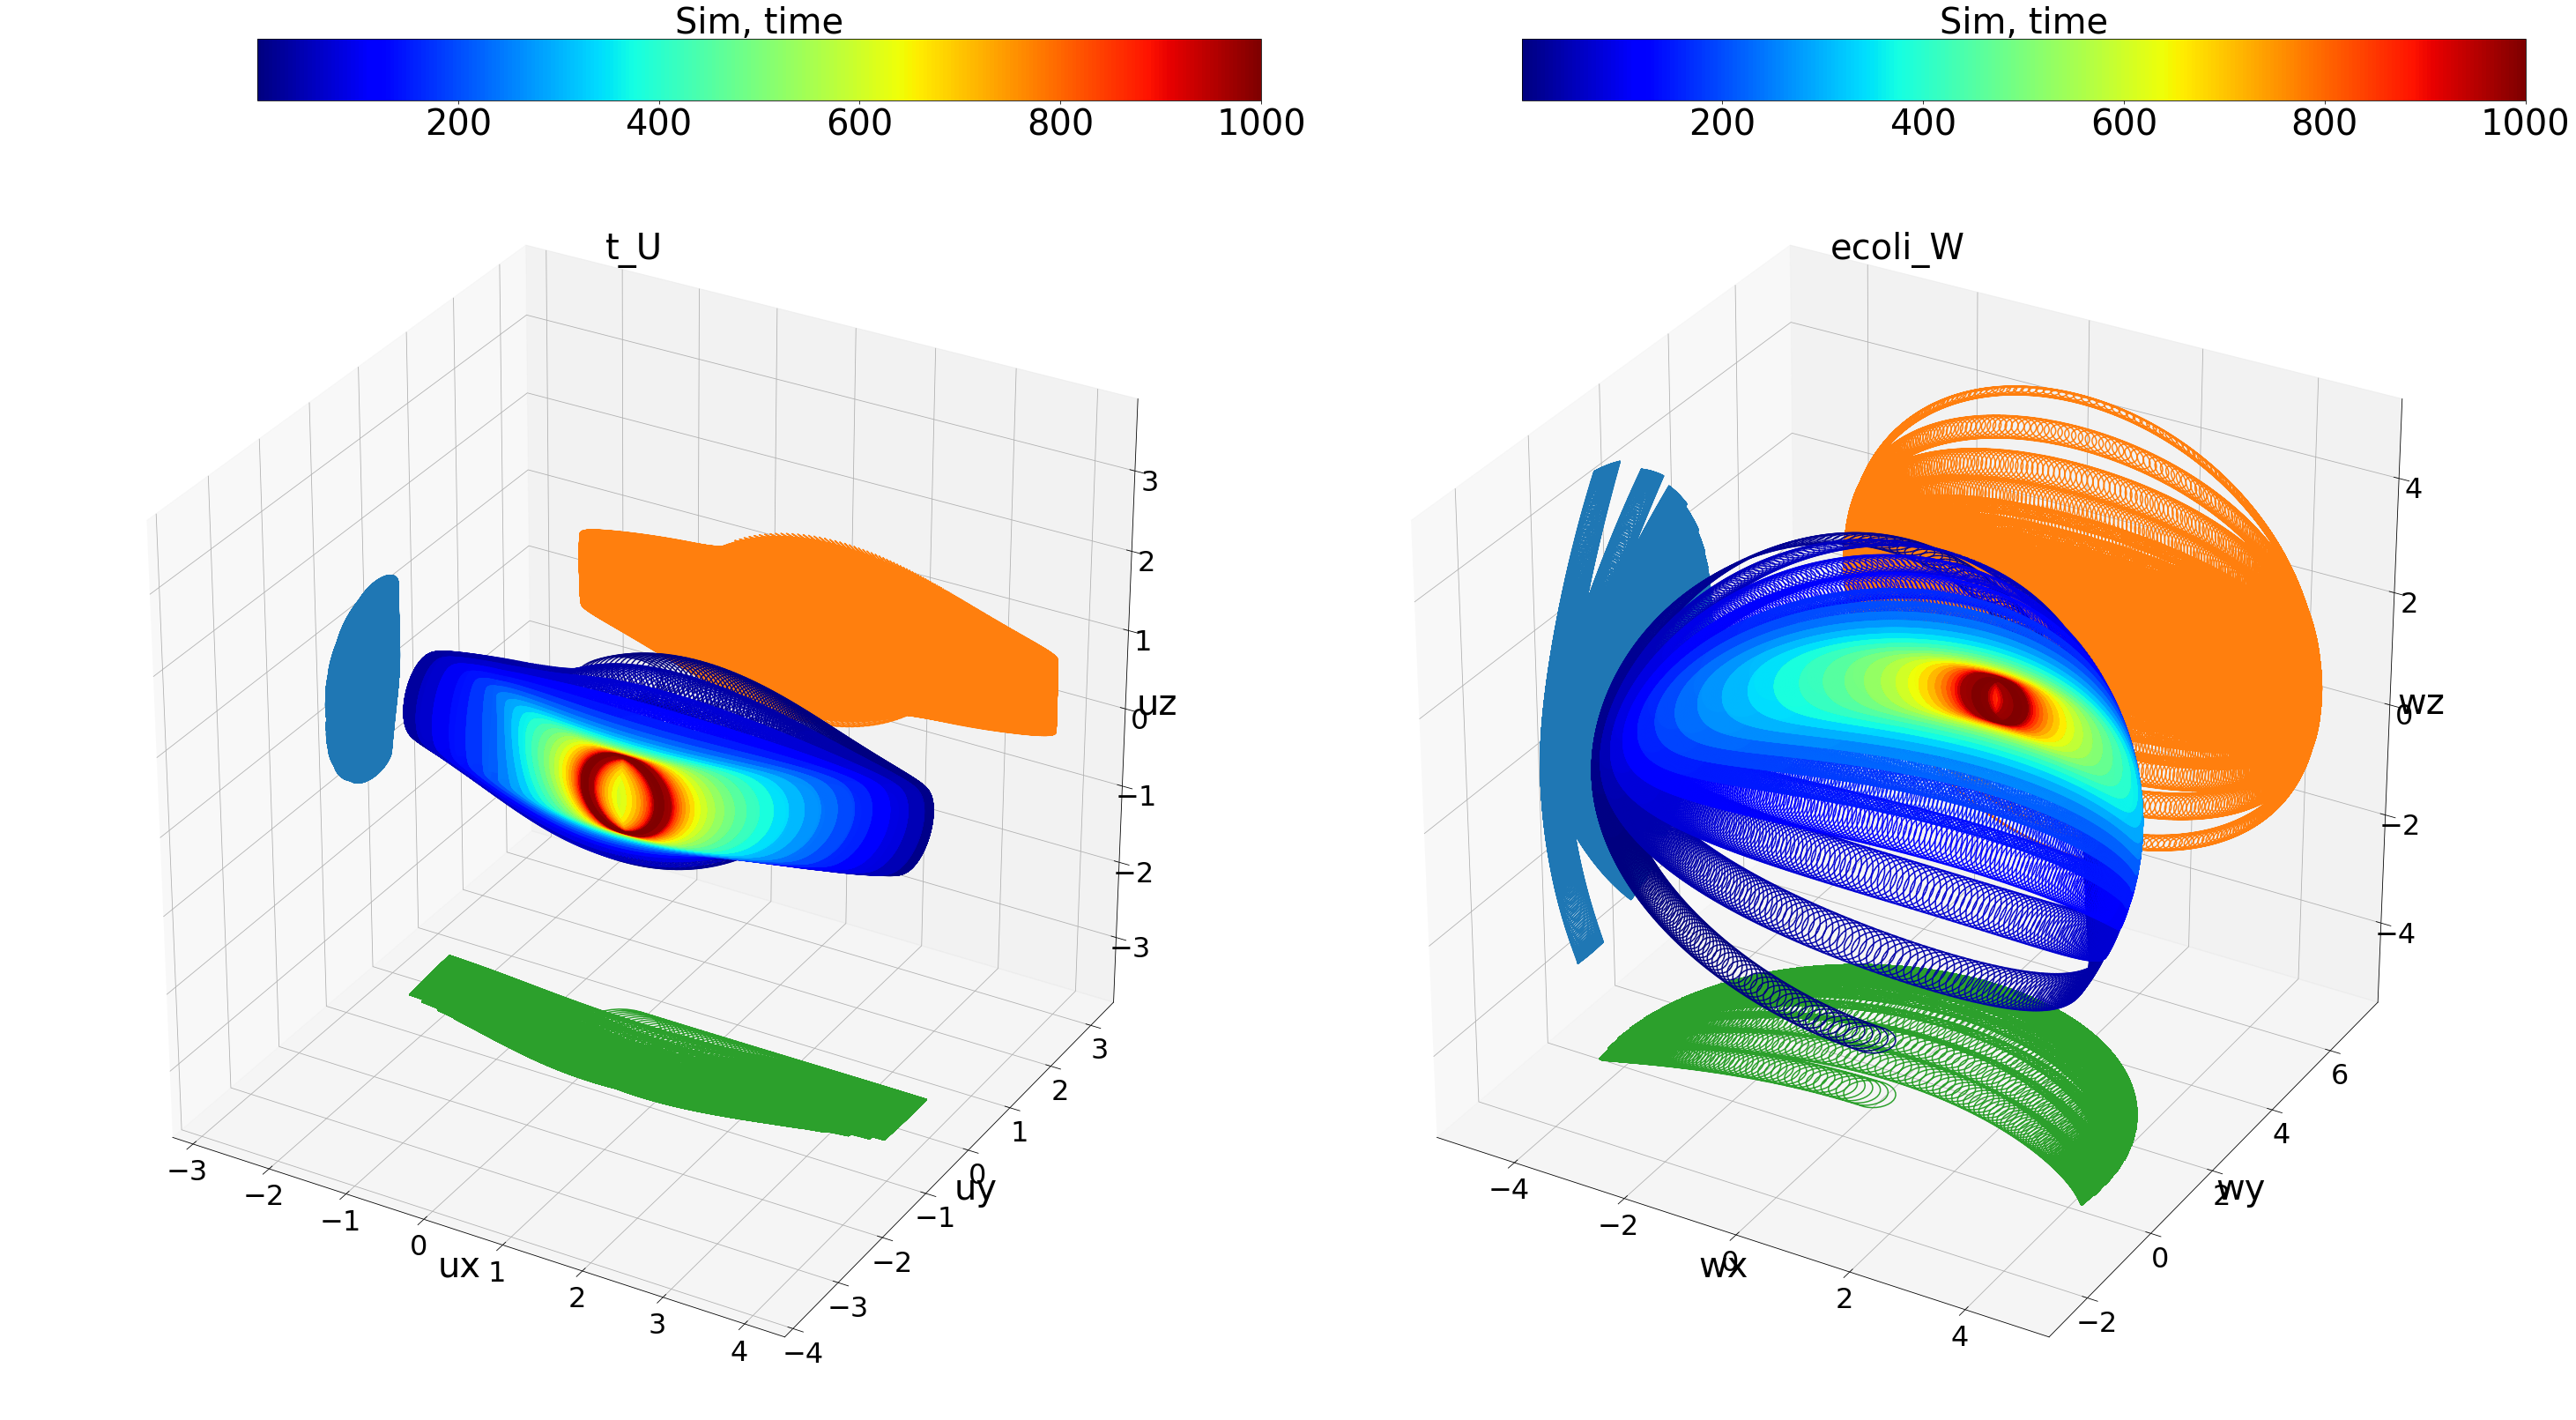

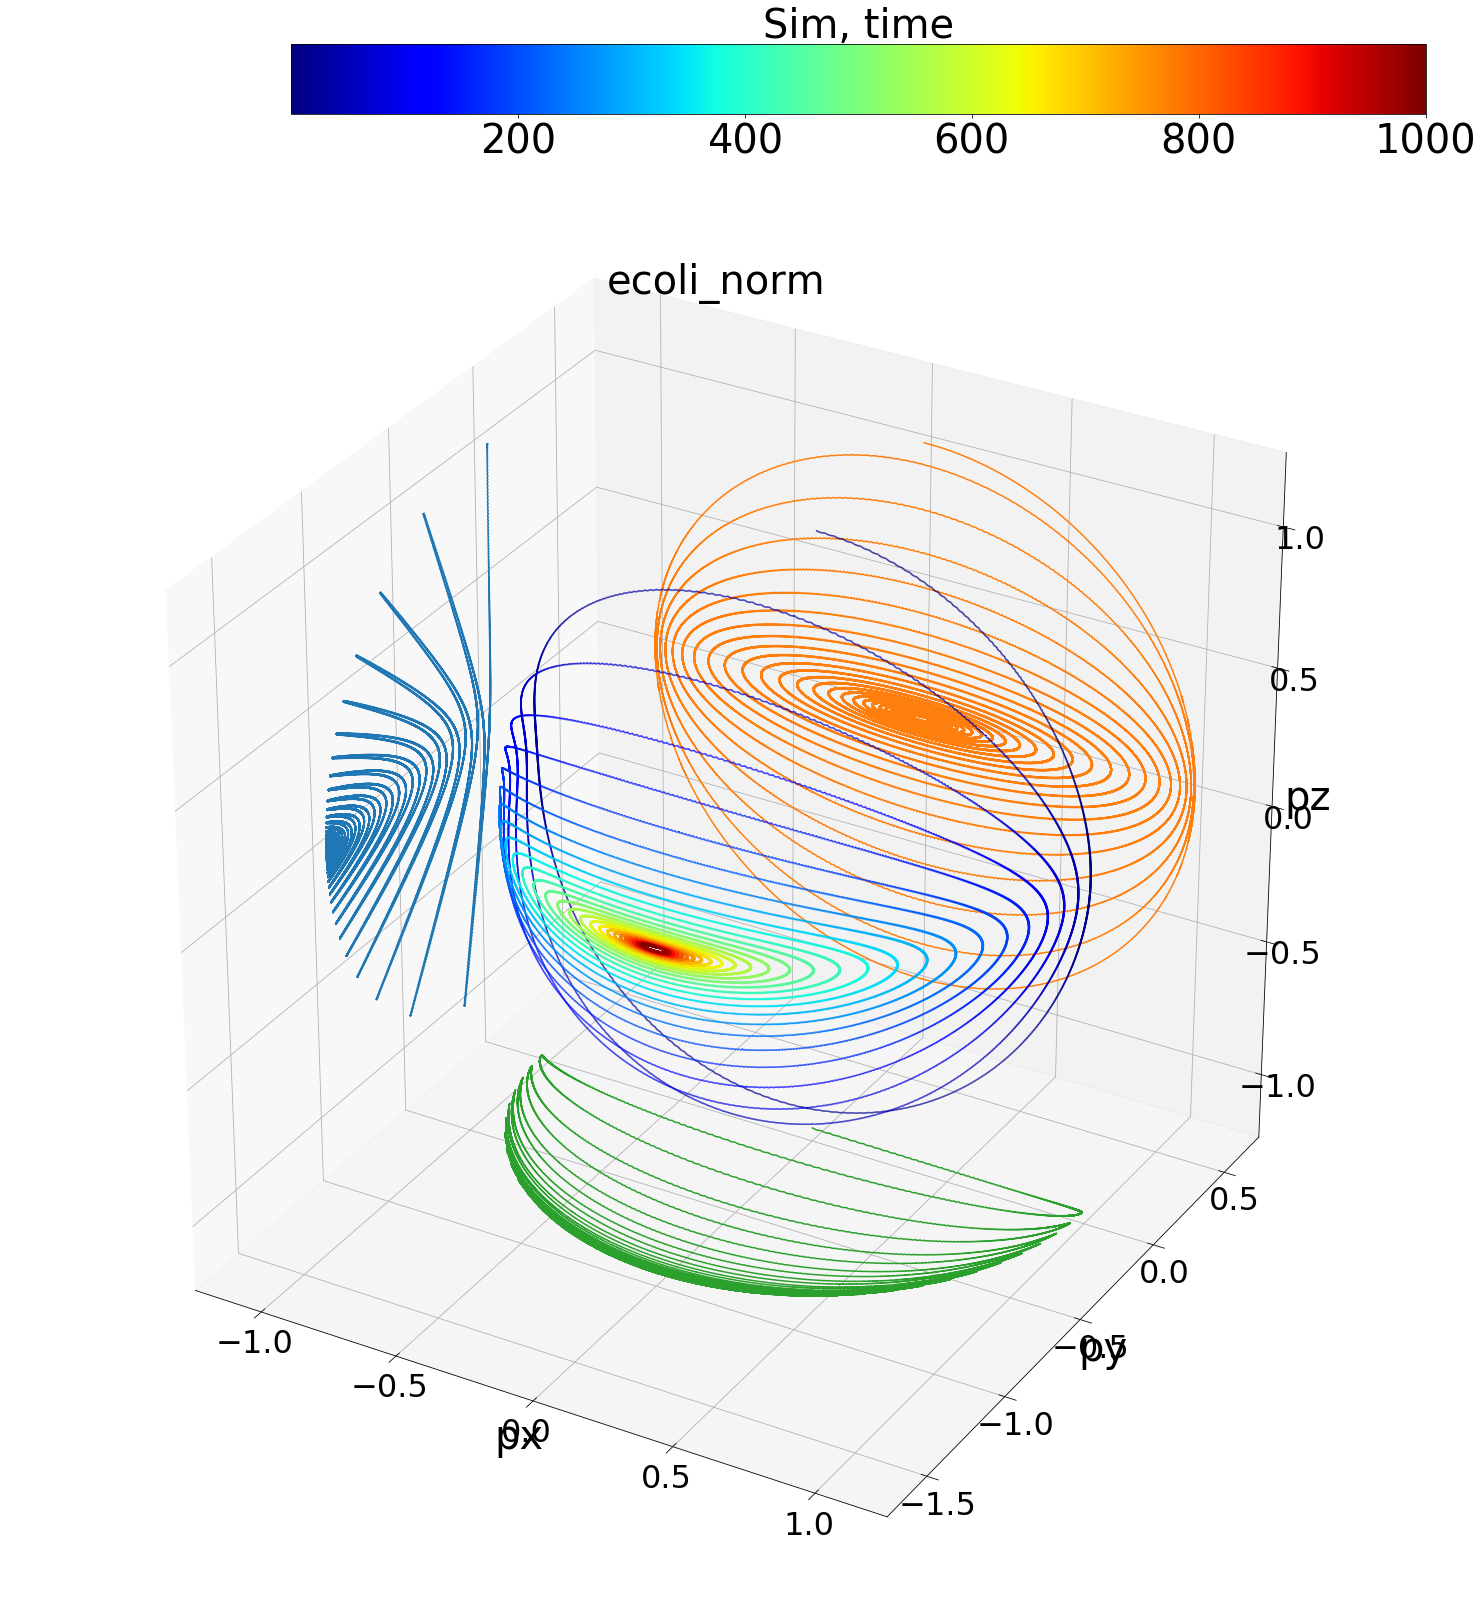

In [269]:
# ecoli case. Simulation vs Table. 

importlib.reload(jm)
eval_dt = np.mean(np.diff(ecoli_t))
max_iter = ecoli_t.size
tcenter = ecoli_center[0]
tnorm = ecoli_norm[0]
update_order = 1
planeShearRate = np.array((1, 0, 0))
# tnorm = np.random.sample(3) - np.ones(3) * 0.5
tnorm = tnorm / np.linalg.norm(tnorm)
lateral_norm = np.random.sample(3) - np.ones(3) * 0.5
lateral_norm = lateral_norm / np.linalg.norm(lateral_norm)
lateral_norm = lateral_norm - tnorm * np.dot(tnorm, lateral_norm)
lateral_norm = lateral_norm / np.linalg.norm(lateral_norm)
print('ini norm=', tnorm, 'tcenter=', tcenter, 'eval_dt=', eval_dt)

# Table_t, Table_theta, Table_phi, Table_psi, Table_eta, \
#   Table_dtheta, Table_dphi, Table_X, Table_U, Table_P \
#   = get_ecoli_table(tnorm, lateral_norm, tcenter, max_iter, eval_dt=eval_dt, 
#                     update_order=update_order, planeShearRate=planeShearRate)

show_ecoli_results(Table_t, Table_theta, Table_phi, Table_psi, Table_dtheta, Table_dphi, 
                   Table_X, Table_U, Table_P)

/home/zhangji/stokes_flow_master/head_Force/motion_ecoli_torque7/ecoli_B01_theta0.00_phi0.00
ecoli_B01_theta0.00_phi0.00 3681


/home/zhangji/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:288: RuntimeWarning: divide by zero encountered in true_divide
/home/zhangji/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:289: RuntimeWarning: divide by zero encountered in true_divide
/home/zhangji/anaconda3/lib/python3.5/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


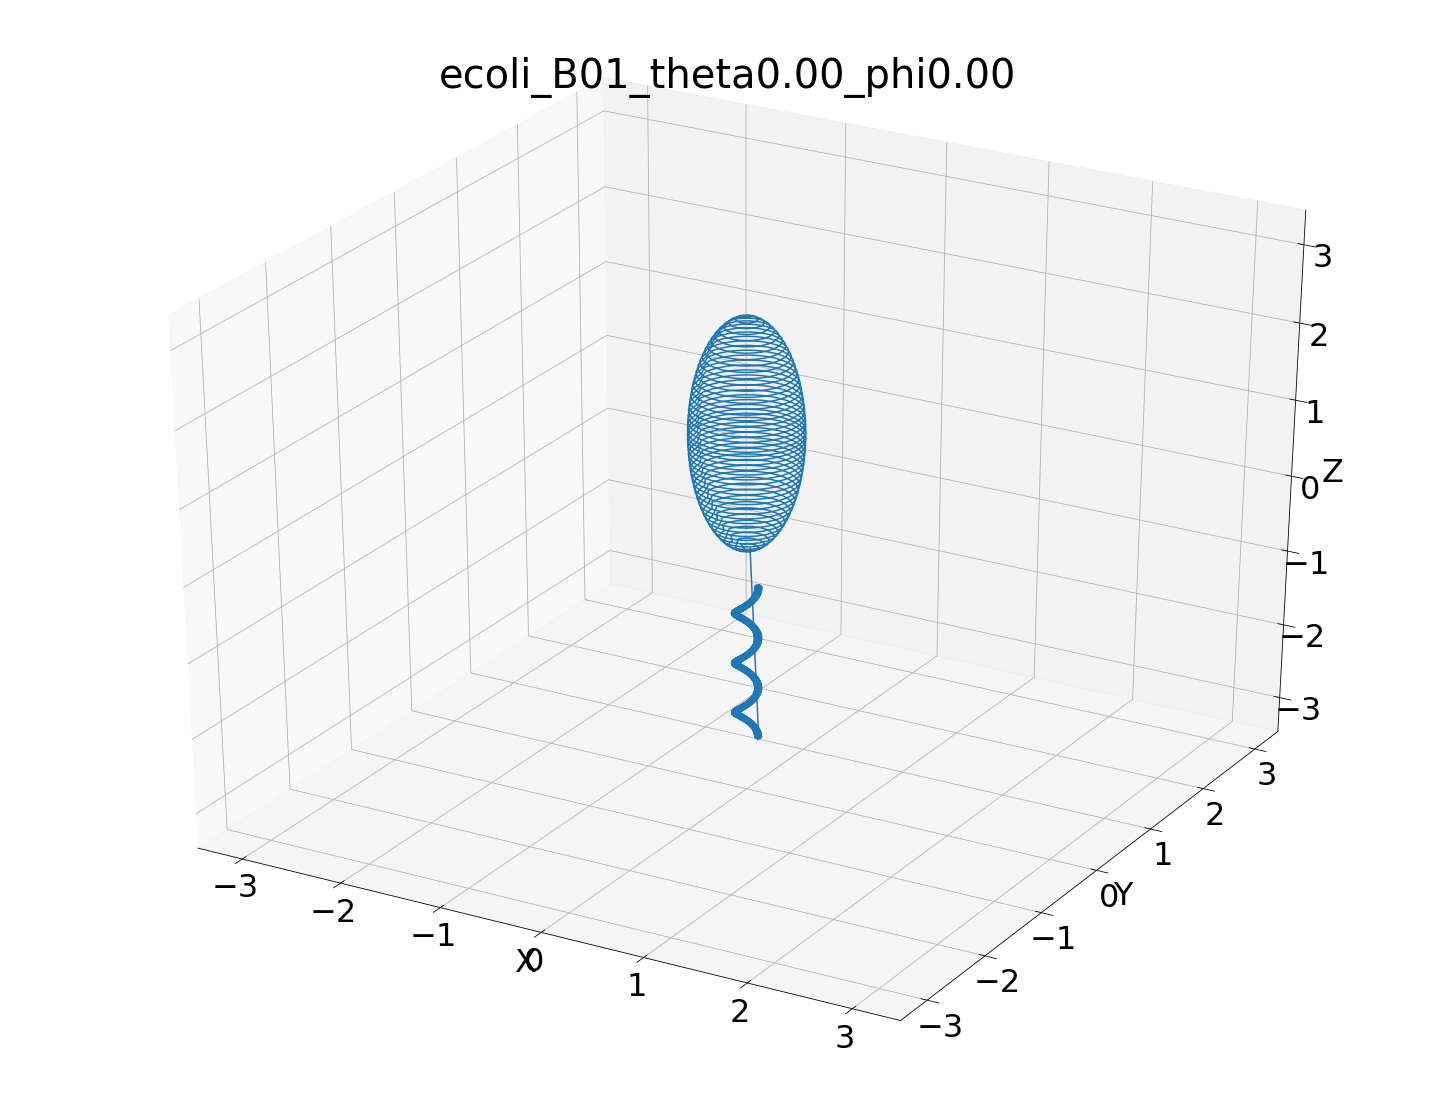

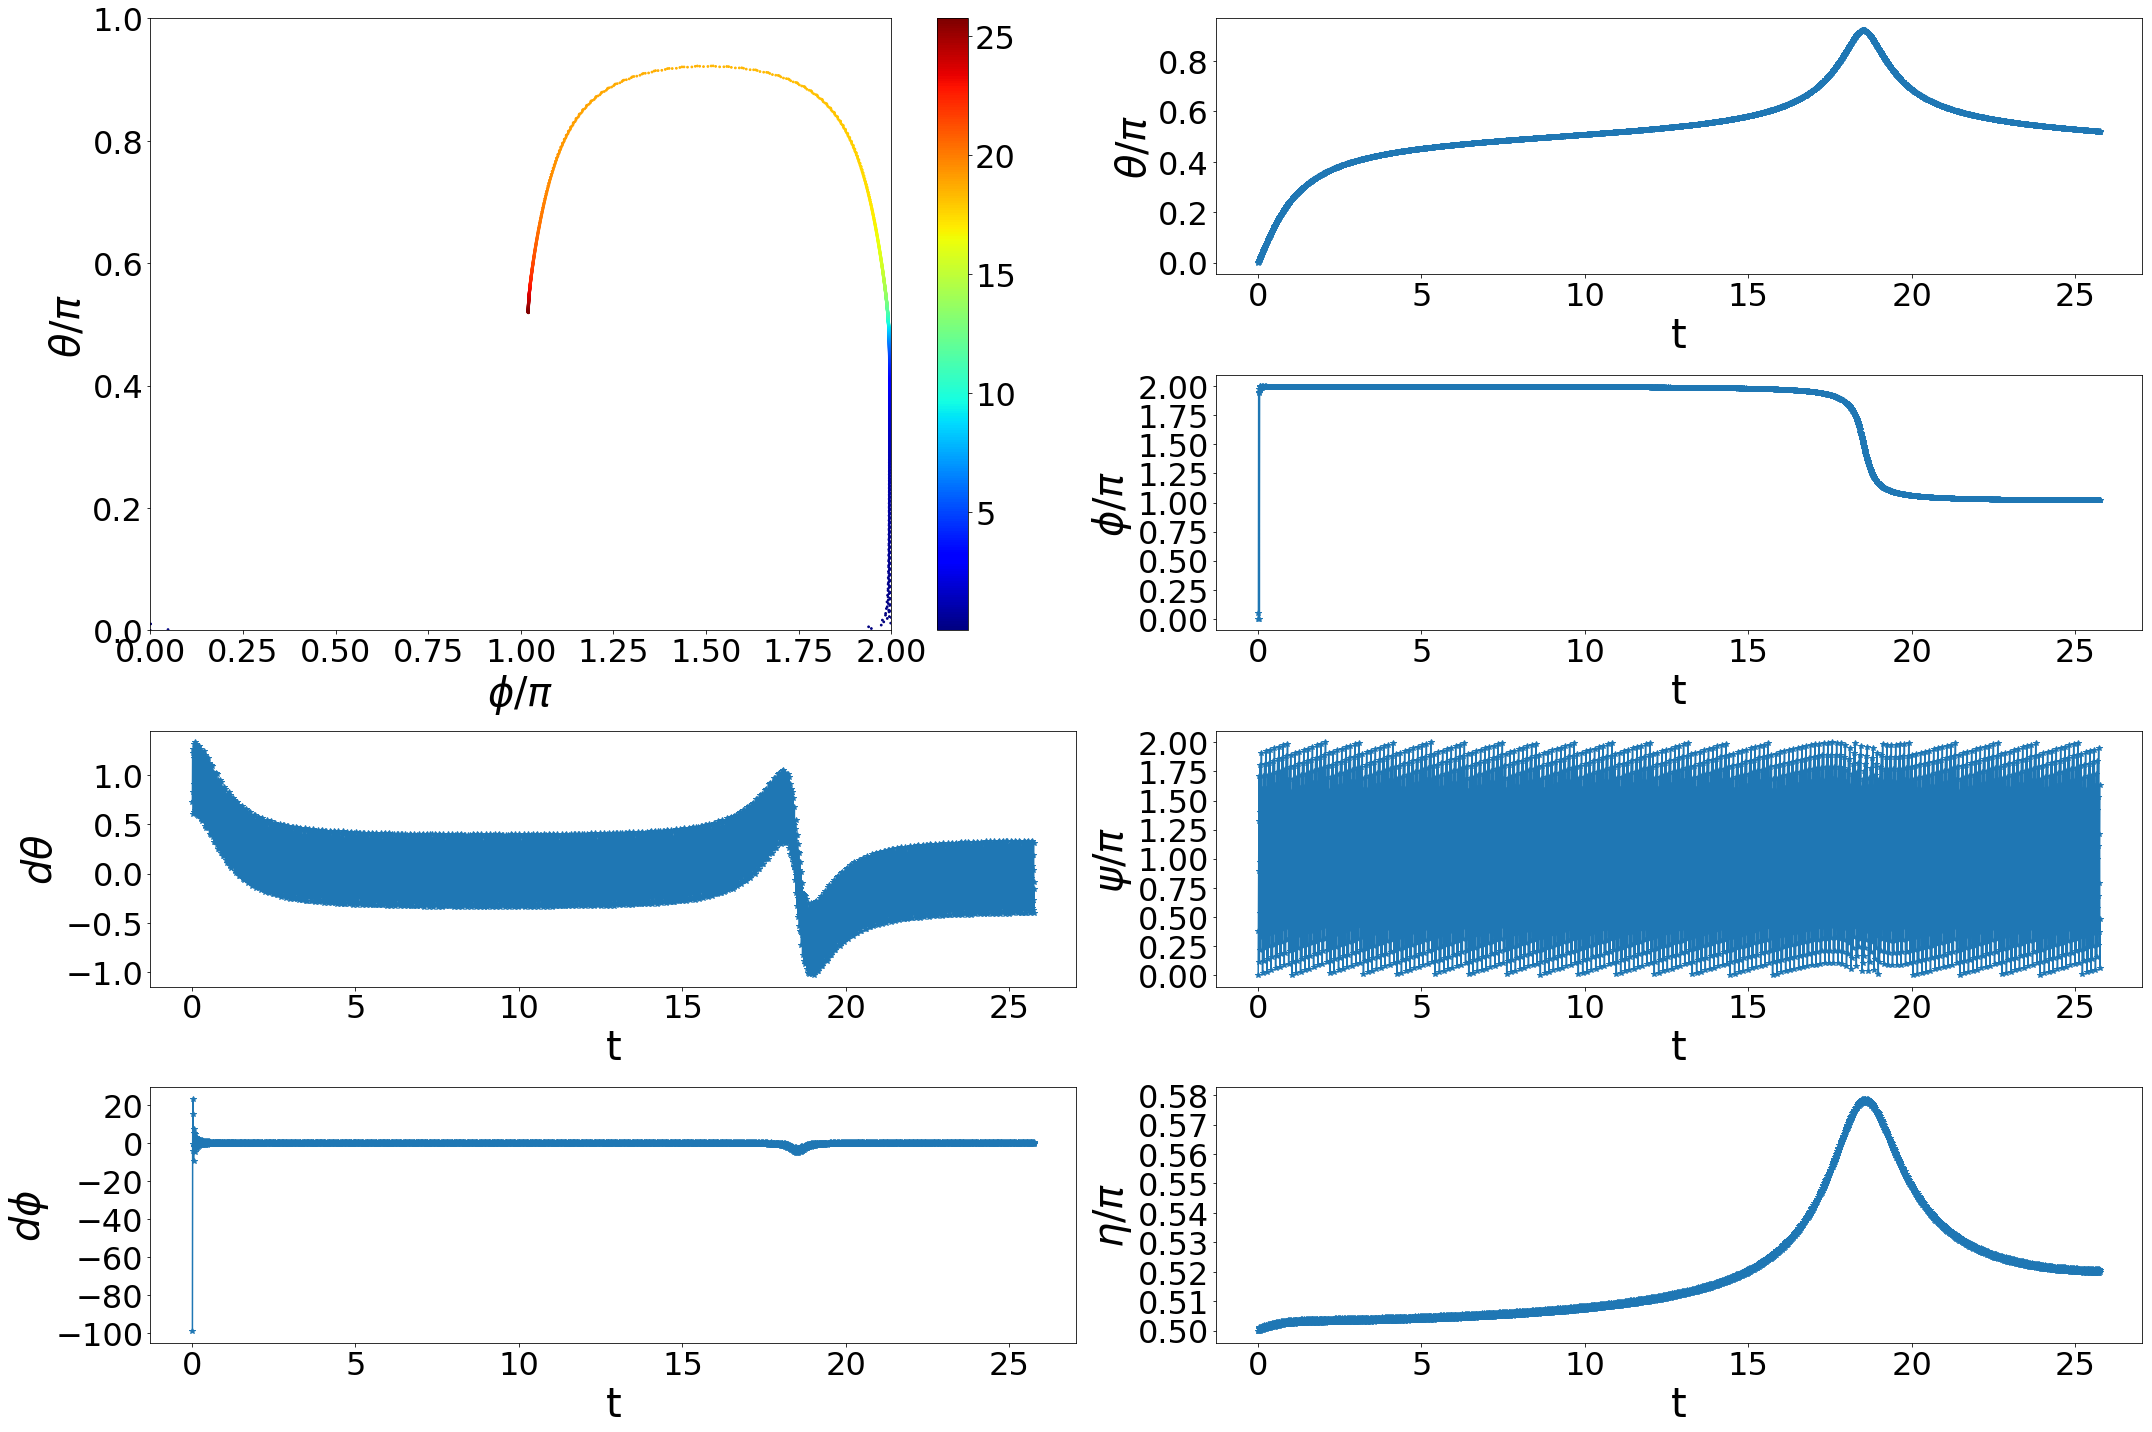

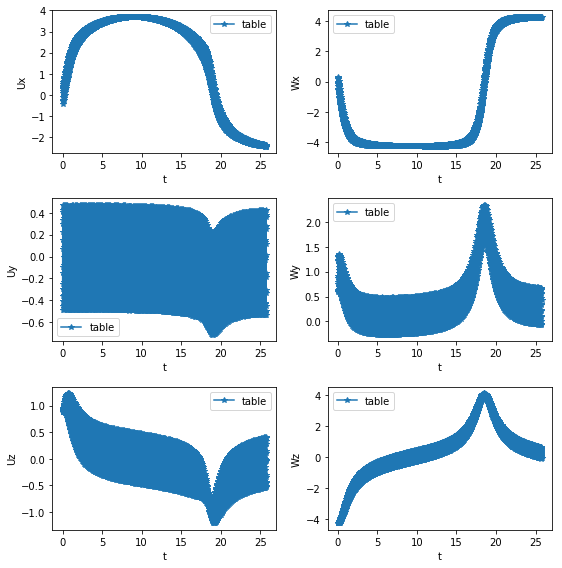

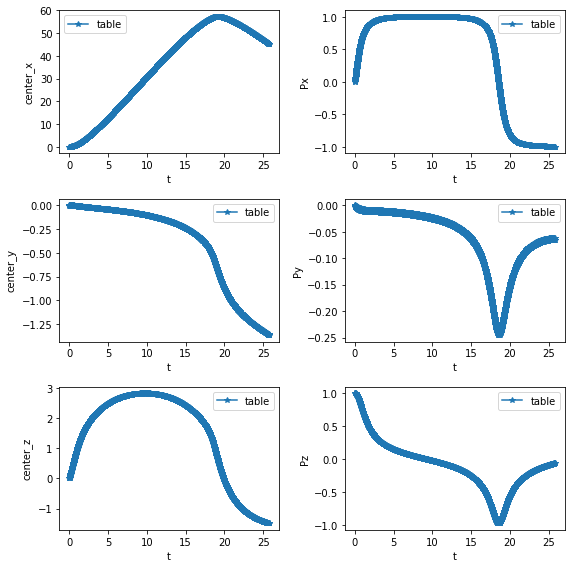

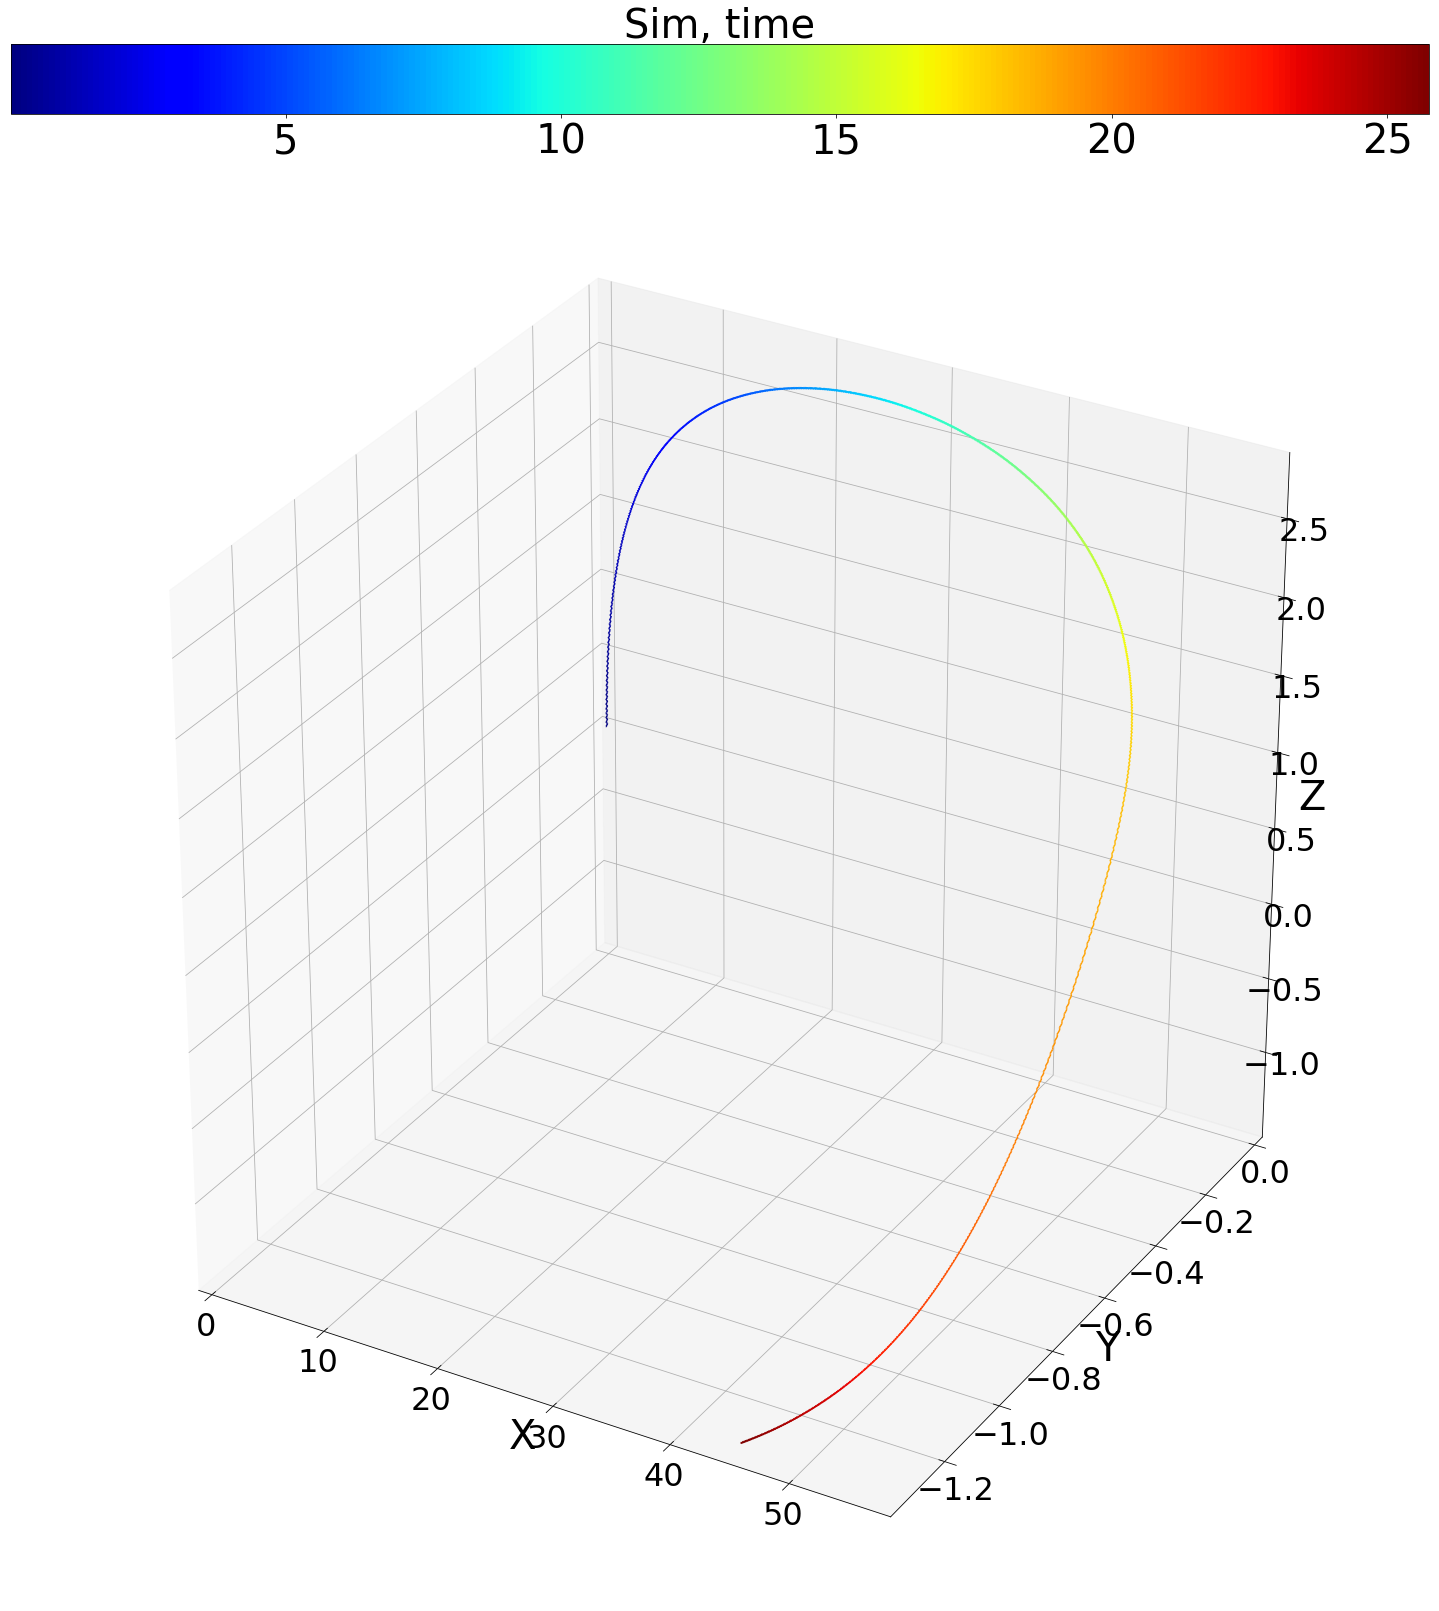

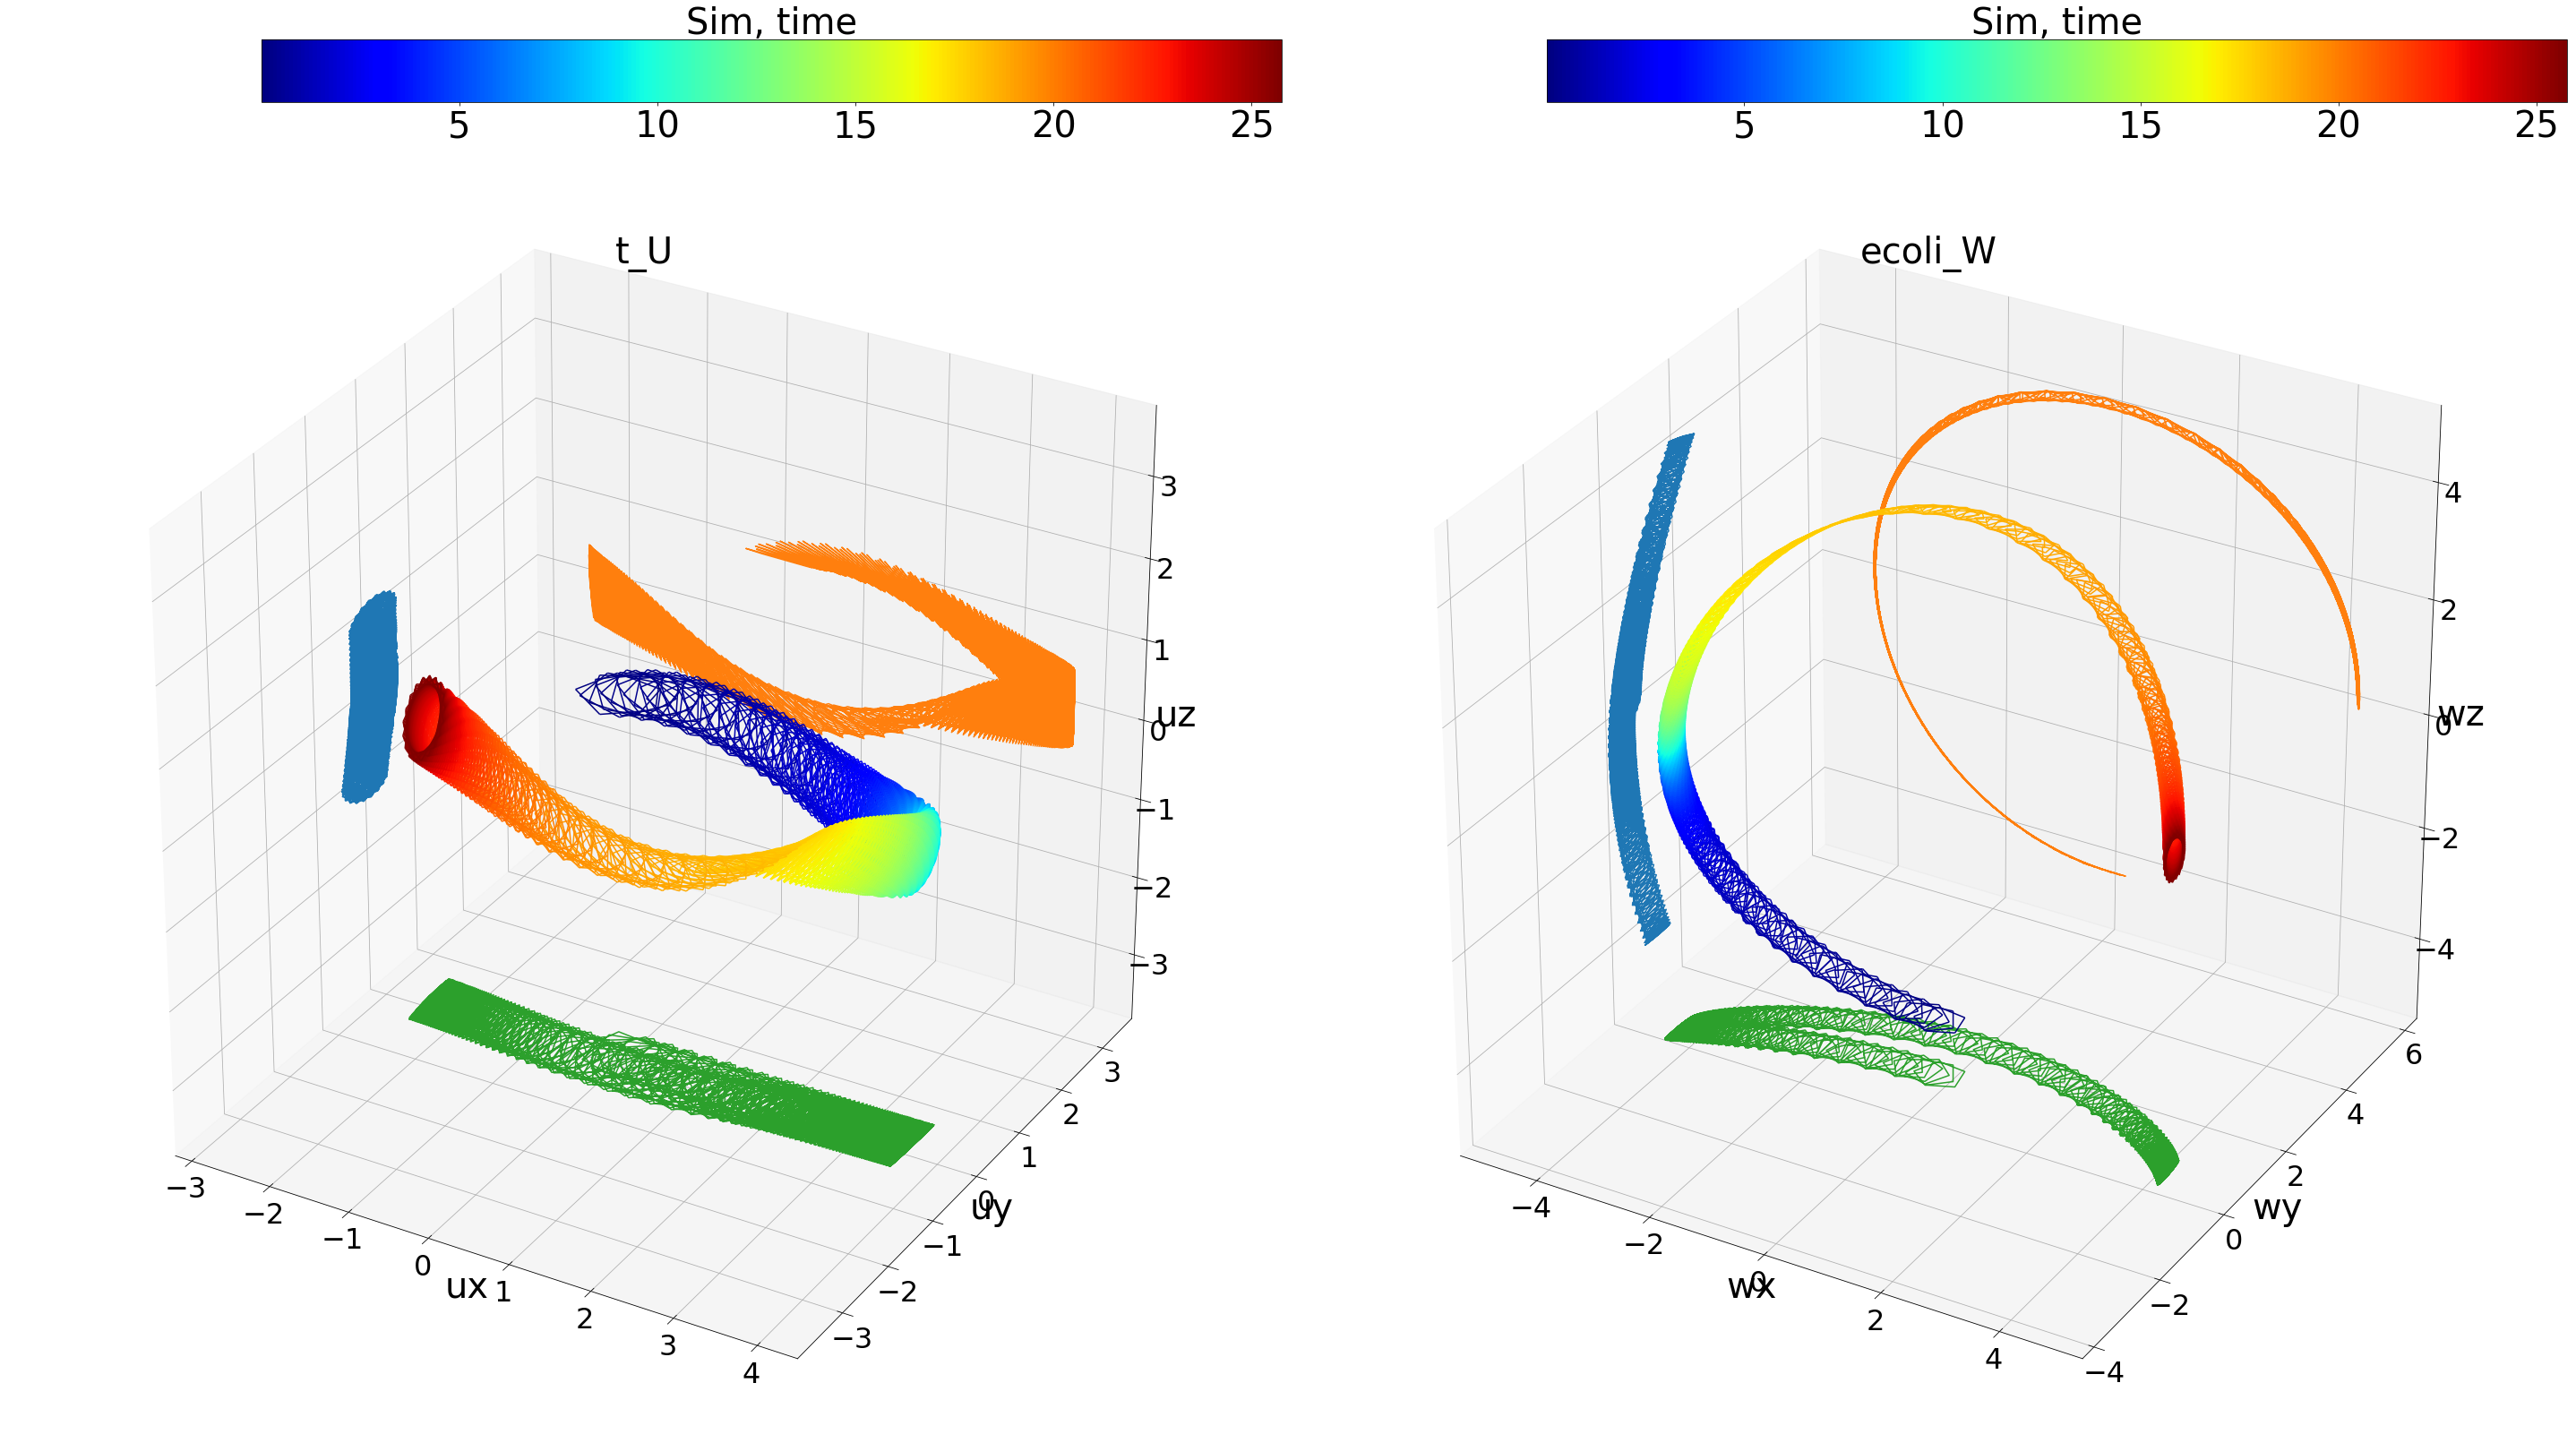

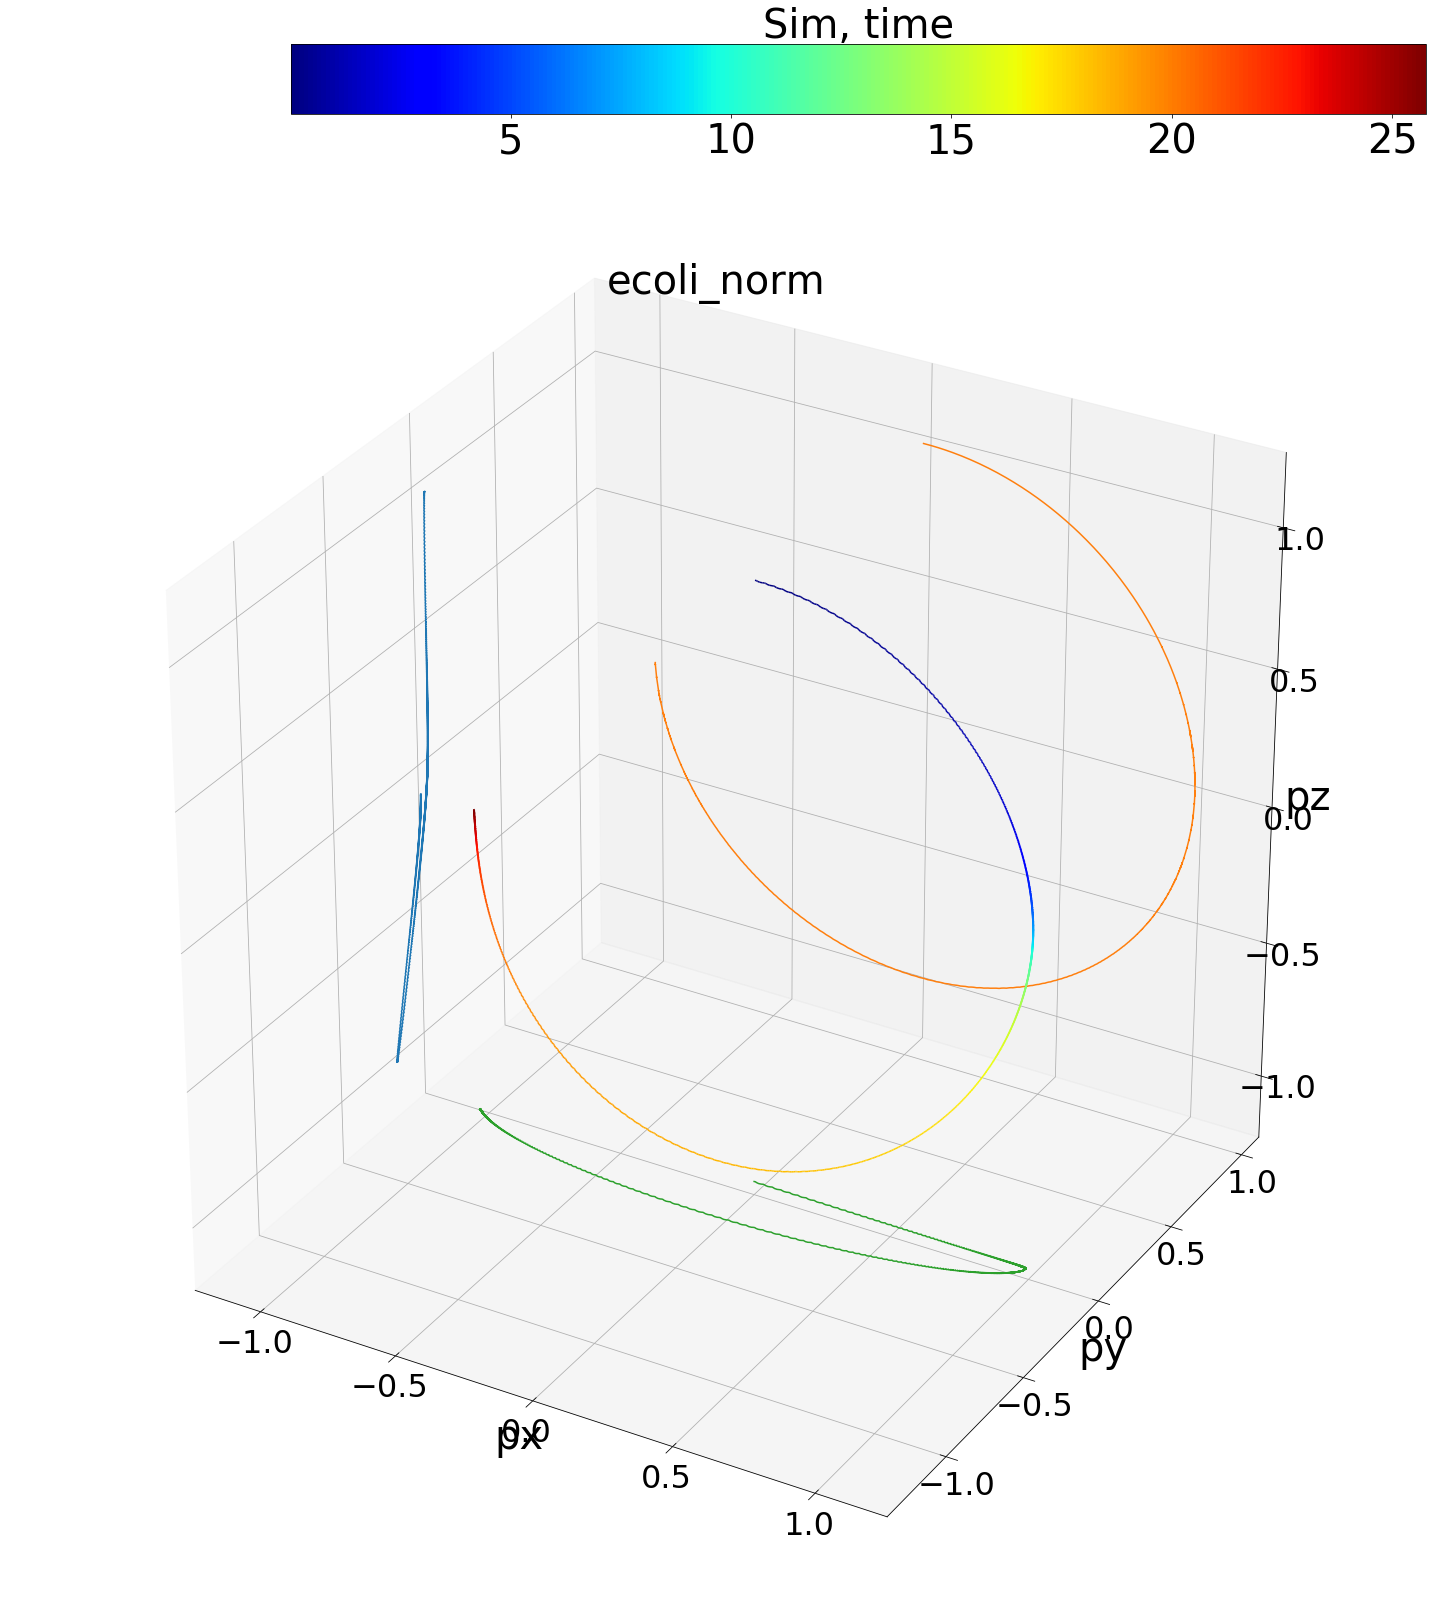

In [317]:
PWD = os.getcwd()
file_handle = 'ecoli_B01_theta0.00_phi0.00'
dir_name = os.path.join(PWD, 'motion_ecoli_torque7', file_handle)
print(dir_name)
ecoli_t, ecoli_theta, ecoli_phi, ecoli_psi, ecoli_dtheta, ecoli_dphi, \
  ecoli_center, ecoli_U, ecoli_norm, ecoli_nodes_list \
  = get_ecoli_date(dir_name, file_handle, ignore_first=1)
show_ecoli_results(ecoli_t, ecoli_theta, ecoli_phi, ecoli_psi, ecoli_dtheta, ecoli_dphi, 
                   ecoli_center, ecoli_U, ecoli_norm)
pass

True

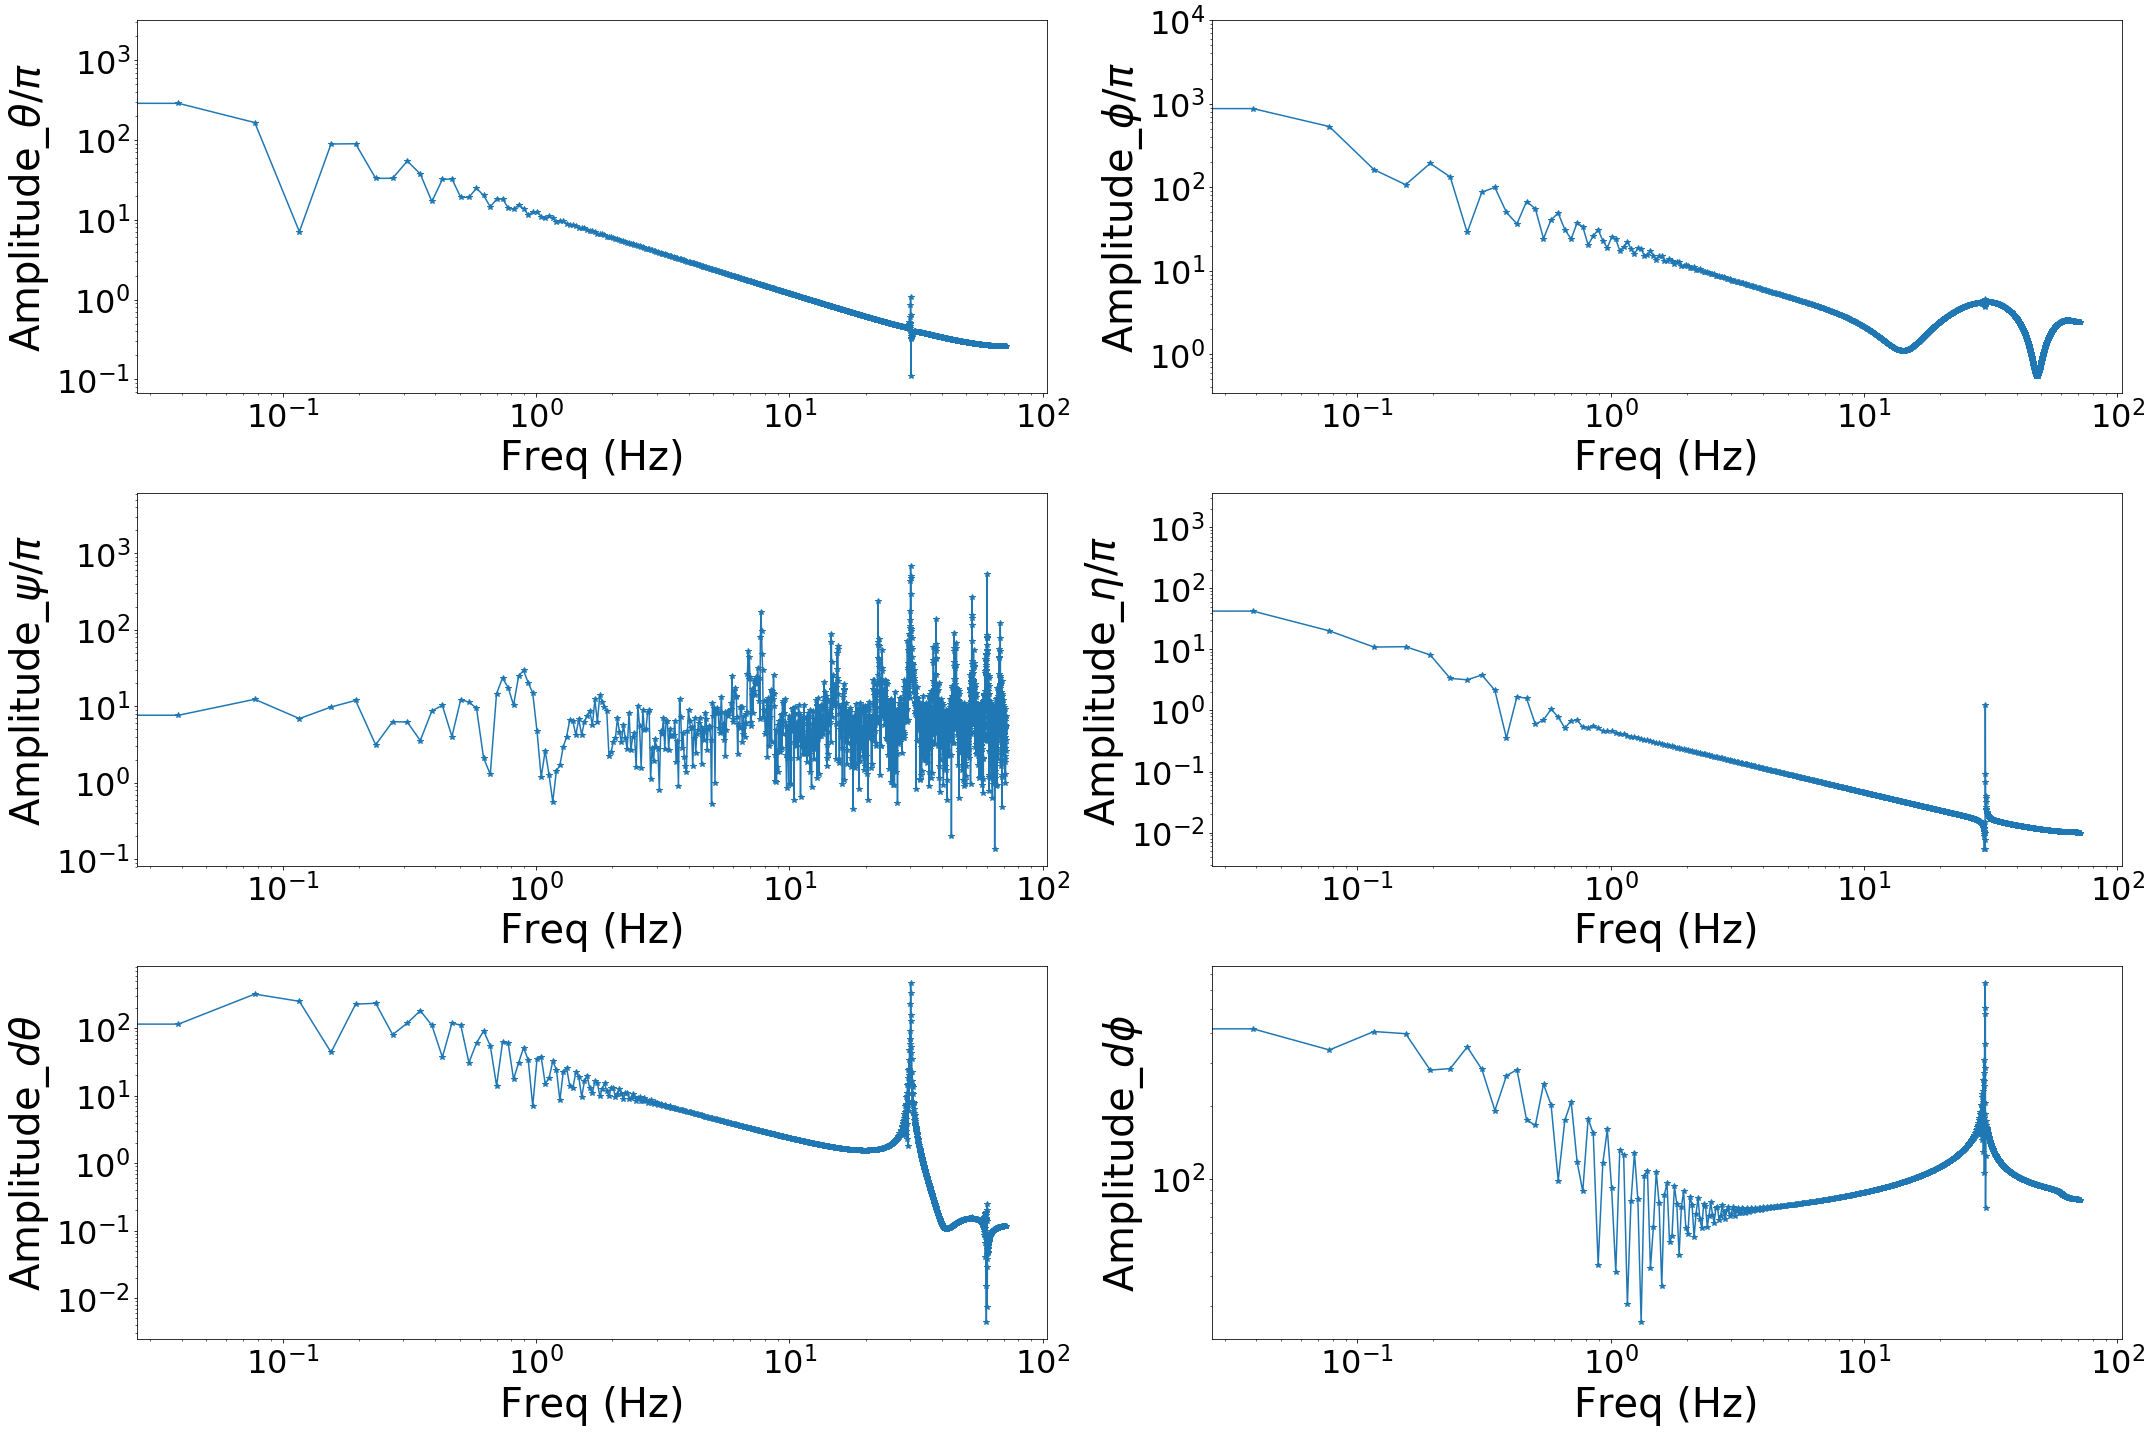

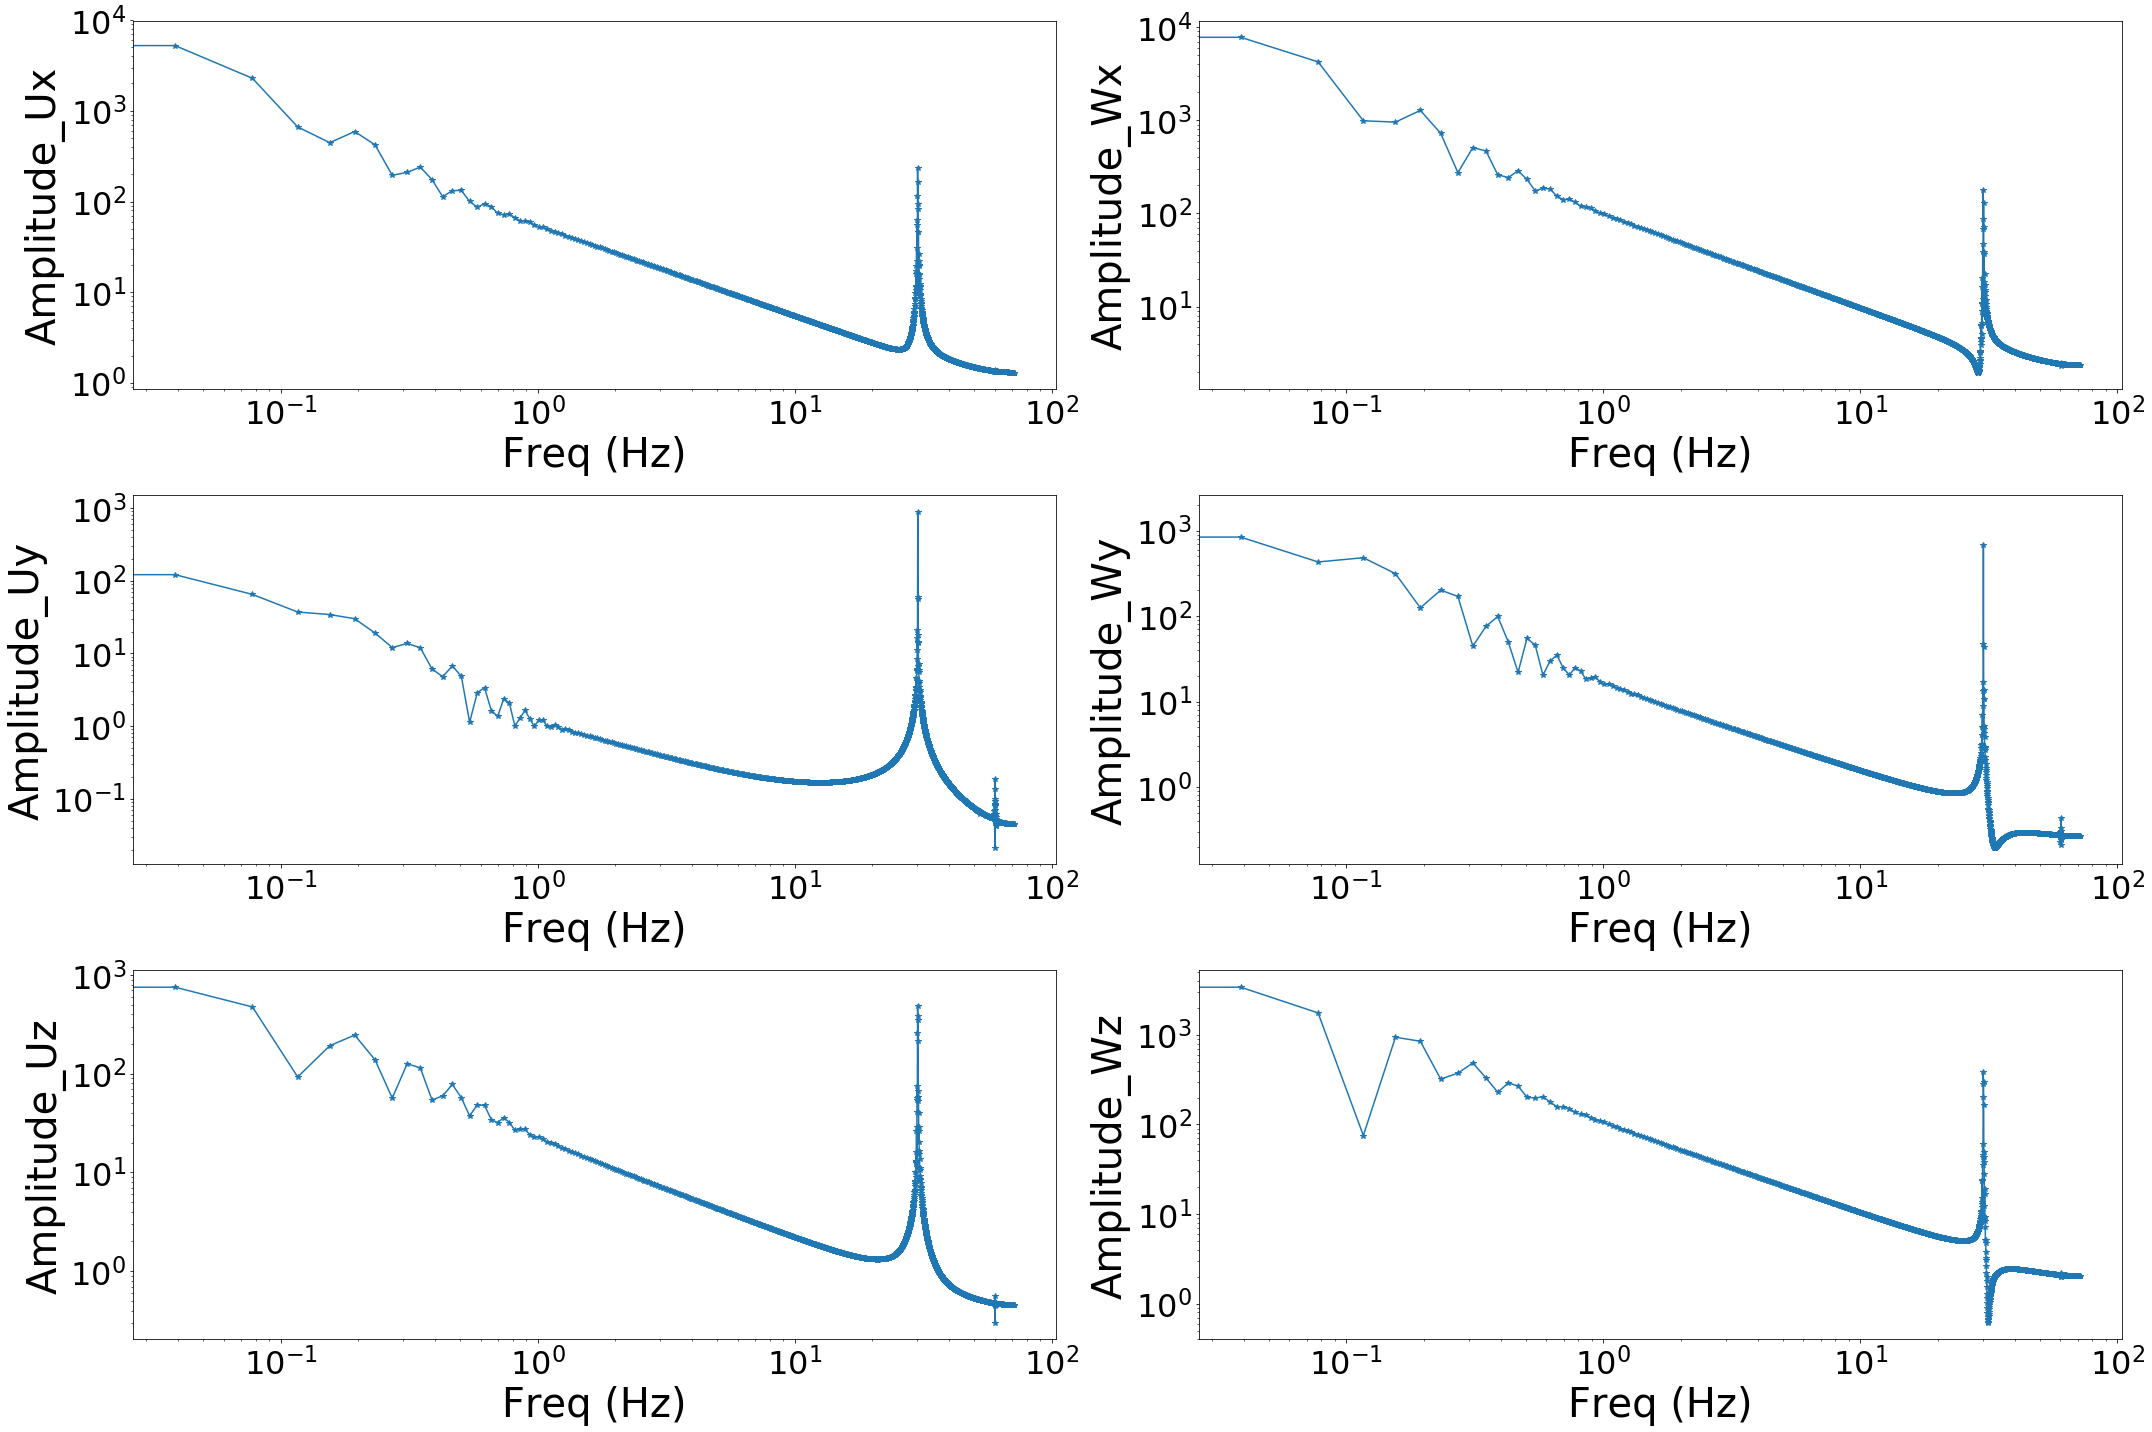

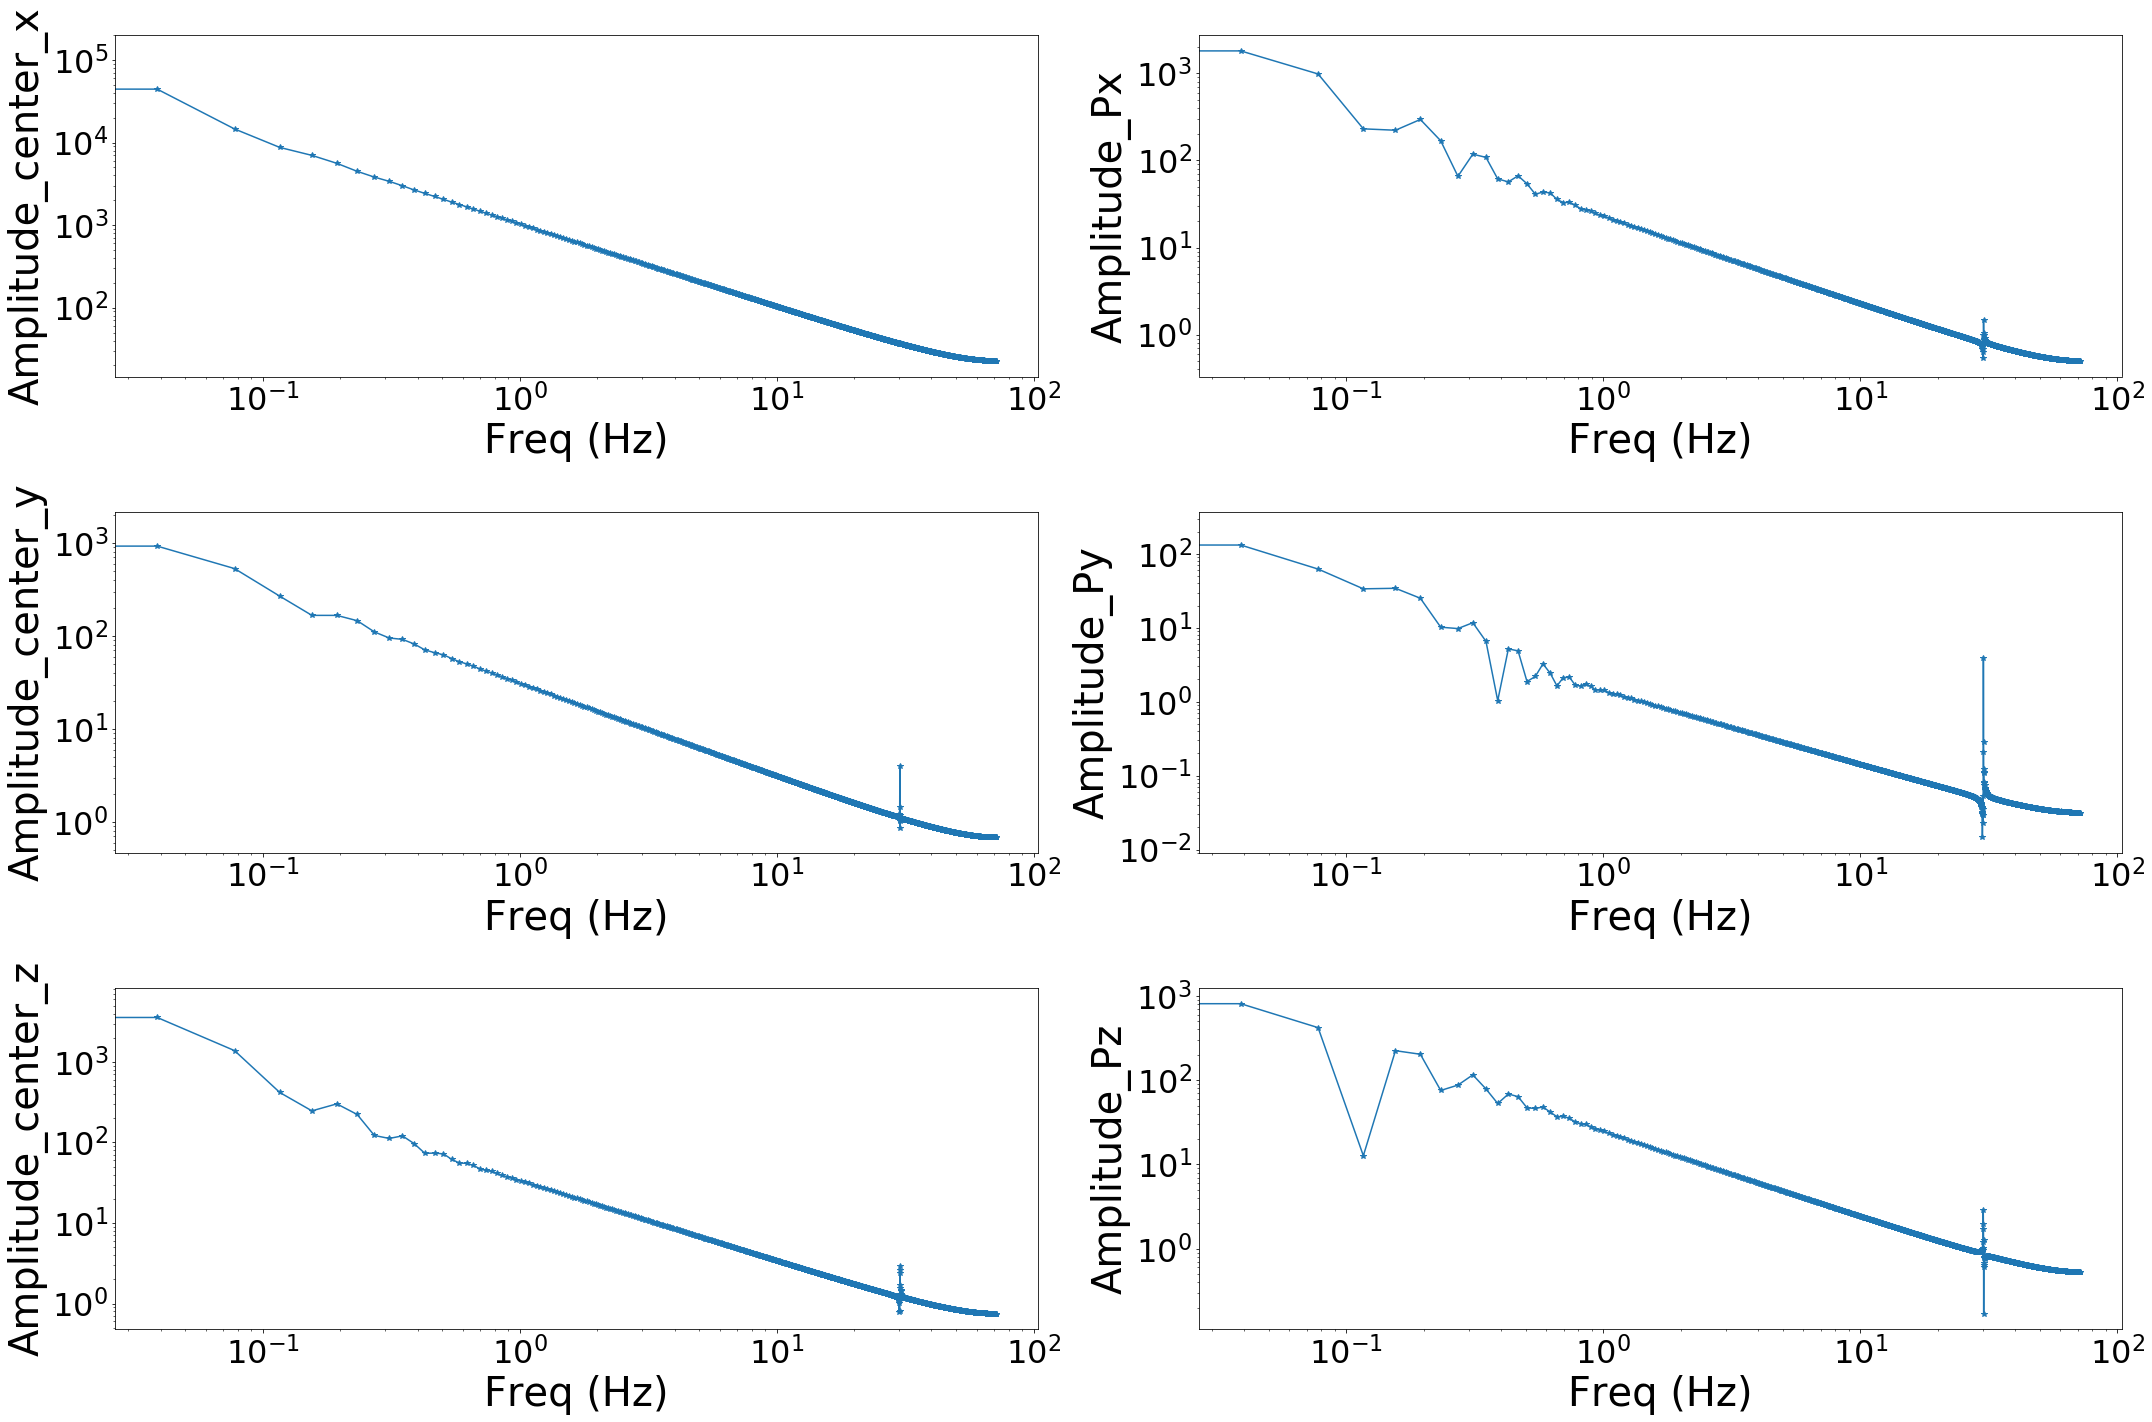

In [318]:
show_ecoli_results_fft(ecoli_t, ecoli_theta, ecoli_phi, ecoli_psi, ecoli_dtheta, ecoli_dphi, 
                   ecoli_center, ecoli_U, ecoli_norm)
# show_ecoli_results_fft(Table_t, Table_theta, Table_phi, Table_psi, Table_dtheta, Table_dphi, 
#                    Table_X, Table_U, Table_P)


In [15]:
from scanf import scanf

aaa = 'hlx_prl_1111_10099.mat'
bbb = scanf('%*c_%d.mat', aaa)[0]
print(bbb)


10099
